Trappist-1 comparing lines with Phoenix models.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import astropy.io.fits as fits
import os
from scipy.io.idl import readsav
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from scipy import interpolate
from astropy.convolution import convolve, Box1DKernel,convolve_fft, Gaussian1DKernel
from astropy.modeling import models, fitting

%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [23]:
mpath = '/home/david/work/muscles/trappist-1/sp_models/'
kpath  = '../COS/' 

In [24]:
#Trappist d and r from peacock paper
d = 12.1*u.pc
r = 0.117*const.R_sun

In [25]:
scale = (r/d.to(u.m))**2
scale

<Quantity 4.75273828e-20>

In [26]:
ksp = os.listdir(kpath)

In [27]:
c_ii = [1334.532 ,1335.708]
n_v = [1238.821,1242.804]
c_iv = [1548.202, 1550.774]

In [28]:
mods = os.listdir(mpath)
mods

['TRAPPIST1_2A_fullres.txt',
 'TRAPPIST1_1A_fullres.txt',
 'TRAPPIST1_2B_fullres.txt']

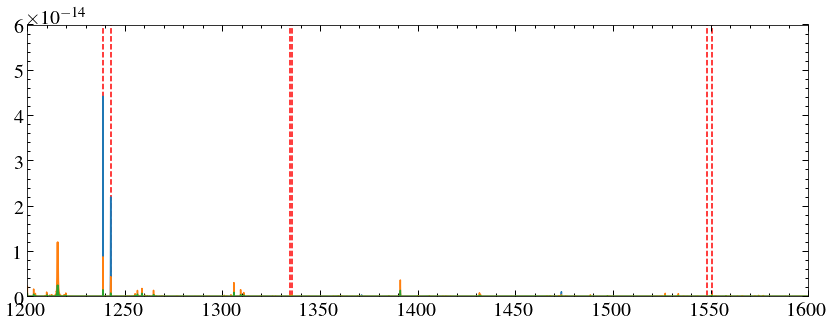

In [109]:
for mod in mods:
    mw, mf = np.loadtxt(mpath+mod, unpack=True, skiprows=1)
    plt.plot(mw, mf*scale)
    plt.xlim(1200, 1600)
    plt.ylim(0.0,0.6e-13)
[plt.axvline(line, ls ='--', c='r', zorder=-10) for line in np.concatenate((c_ii, n_v, c_iv))]

In [30]:
def model_convolve(mw, mf, w, res): #convolves a model with a gaussian
    res_pix = (res * len(w)) / (2.3548*(w[-1]-w[0])) #convert resolution to pixel scale
    mf1 = interpolate.interp1d(mw, mf, bounds_error=False, fill_value=0.)(w) #interpolate model onto measured wavelength
    gauss = Gaussian1DKernel(stddev=res_pix) #set up Gaussian
    new_mf = convolve_fft(mf1, gauss) #convolve model
    return new_mf


In [31]:
mods

['TRAPPIST1_2A_fullres.txt',
 'TRAPPIST1_1A_fullres.txt',
 'TRAPPIST1_2B_fullres.txt']

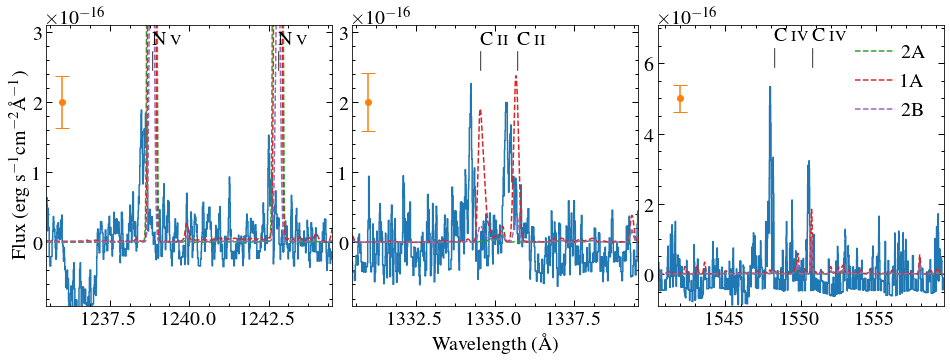

In [32]:
mw2a, mf2a = np.loadtxt(mpath+mods[0], unpack=True, skiprows=1)
mw1a, mf1a = np.loadtxt(mpath+mods[1], unpack=True, skiprows=1)
mw2b, mf2b = np.loadtxt(mpath+mods[2], unpack=True, skiprows=1)
mf2a, mf1a, mf2b = mf2a*scale, mf1a*scale, mf2b*scale
res=0.1

plt.subplots_adjust(top = 0.93, right = 0.99, left = 0.1, bottom = 0.15, wspace = 0.07)

plt.subplot(131)
data = readsav(kpath+ksp[0])
flux = convolve(data['Flux'],Box1DKernel(5))
error =  convolve(data['Err'],Box1DKernel(5))
plt.step(data['Wave'], flux)
plt.ylim(-0.9e-16,3.1e-16)
plt.xlim(1235.5, 1244.5)
[plt.annotate('N\,{\sc v}\n$|$',(n, 2.5e-16),size=20) for n in n_v]
plt.ylabel('Flux (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)', size=20)
err = error[(data['Wave']>1235) & (data['Wave']<1245)]
plt.errorbar(1236, 2e-16, yerr= np.median(err), capsize = 7, marker='o')

mf2a_c = model_convolve(mw2a, mf2a, data['Wave'], res)
mf1a_c = model_convolve(mw1a, mf1a, data['Wave'], res)
mf2b_c = model_convolve(mw2b, mf2b, data['Wave'], res)
plt.plot(data['Wave'], mf2a_c, ls='--')
plt.plot(data['Wave'], mf1a_c, ls='--')
plt.plot(data['Wave'], mf2b_c, ls='--')

plt.subplot(132)
plt.step(data['Wave'], flux)
plt.ylim(-0.9e-16, 3.1e-16)
plt.xlim(1330.5, 1339.5)
[plt.annotate('C\,{\sc ii}\n$|$',(c, 2.5e-16),size=20) for c in c_ii]
plt.xlabel('Wavelength (\AA)', size=20)
err = error[(data['Wave']>1330) & (data['Wave']<1340)]
plt.errorbar(1331, 2e-16, yerr= np.median(err), capsize = 7, marker='o')
plt.plot(data['Wave'], mf2a_c, ls='--')
plt.plot(data['Wave'], mf1a_c, ls='--')
plt.plot(data['Wave'], mf2b_c, ls='--')


data = readsav(kpath+ksp[1])
flux = convolve(data['Flux'],Box1DKernel(5))
error =  convolve(data['Err'],Box1DKernel(5))
plt.subplot(133)
plt.step(data['Wave'], flux)
plt.ylim(-0.9e-16, 7.1e-16)
plt.xlim(1540.5, 1559.5)
[plt.annotate('C\,{\sc iv}\n$|$',(c, 6e-16),size=20) for c in c_iv]
err = error[(data['Wave']>1540) & (data['Wave']<1560)]
plt.errorbar(1542, 5e-16, yerr= np.median(err), capsize = 7, marker='o')#, ecolor='C1')


mf2a_c = model_convolve(mw2a, mf2a, data['Wave'], res)
mf1a_c = model_convolve(mw1a, mf1a, data['Wave'], res)
mf2b_c = model_convolve(mw2b, mf2b, data['Wave'], res)
plt.plot(data['Wave'], mf2a_c, ls='--', label= '2A')
plt.plot(data['Wave'], mf1a_c, ls='--', label='1A')
plt.plot(data['Wave'], mf2b_c, ls='--', label='2B')
plt.legend()

20190415 I have a combined hst file, so can do a comparision of the given model fluxes to the Hst

In [99]:
data = Table.read('../combined/TRAPPIST-1_hst+phoenix_v1.ecsv')

In [37]:
mlines = np.genfromtxt('phoenix_model_lines.txt', delimiter='\t', names=True, dtype=None,encoding=None)

In [38]:
mlines.dtype.names

('Species', 'lambda_angst', 'Model_1A', 'Model_2A', 'Model_2B', 'f0')

In [39]:
mlines['lambda_angst'] = mlines['lambda_angst']*u.AA

In [40]:
unit = 1e-18*u.erg/u.s /u.cm**2
mlines['Model_1A'], mlines['Model_2A'], mlines['Model_2B'] = mlines['Model_1A']*unit, mlines['Model_2A']*unit, mlines['Model_2B']*unit

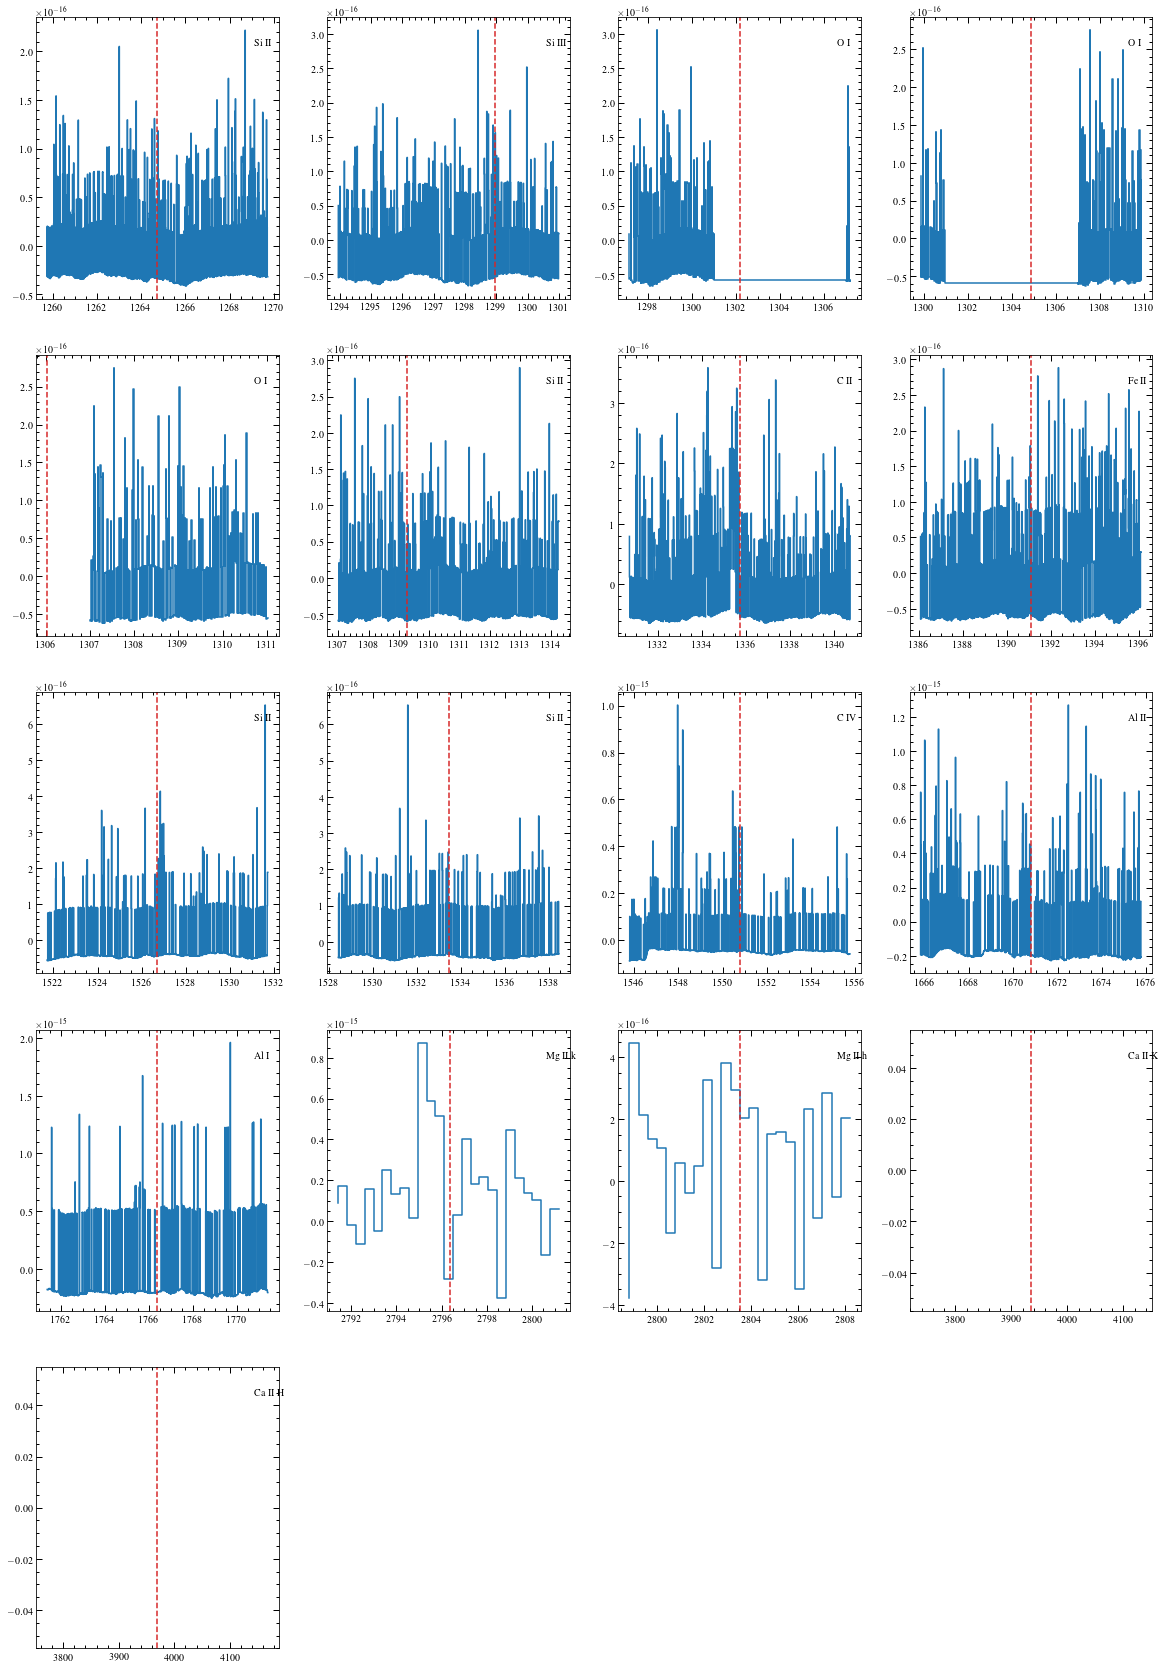

In [17]:
lines = mlines['lambda_angst']
plt.figure(figsize=(20, 30))
for i in range(len(lines)):
    line = lines[i]
    plt.subplot(5,4,i+1)
    mask = (data['WAVELENGTH'] > line-5) & (data['WAVELENGTH'] < line+5)
    plt.step(data['WAVELENGTH'][mask], data['FLUX'][mask])
    plt.axvline(line, ls='--', c='C3')
    plt.annotate(mlines['Species'][i], (0.9, 0.9), xycoords='axes fraction')
    

Ok so we have most of them. Oi lines are wiped out by airglow, I'll take another look at those and see if there's any way to improve. No- the airglow lines are broad and completaly dominate.

In [41]:
nolinesmask = (mlines['Species'] != 'O I')&(mlines['Species'] != 'Ca II K')&(mlines['Species'] != 'Ca II H')
dlines = mlines[nolinesmask]

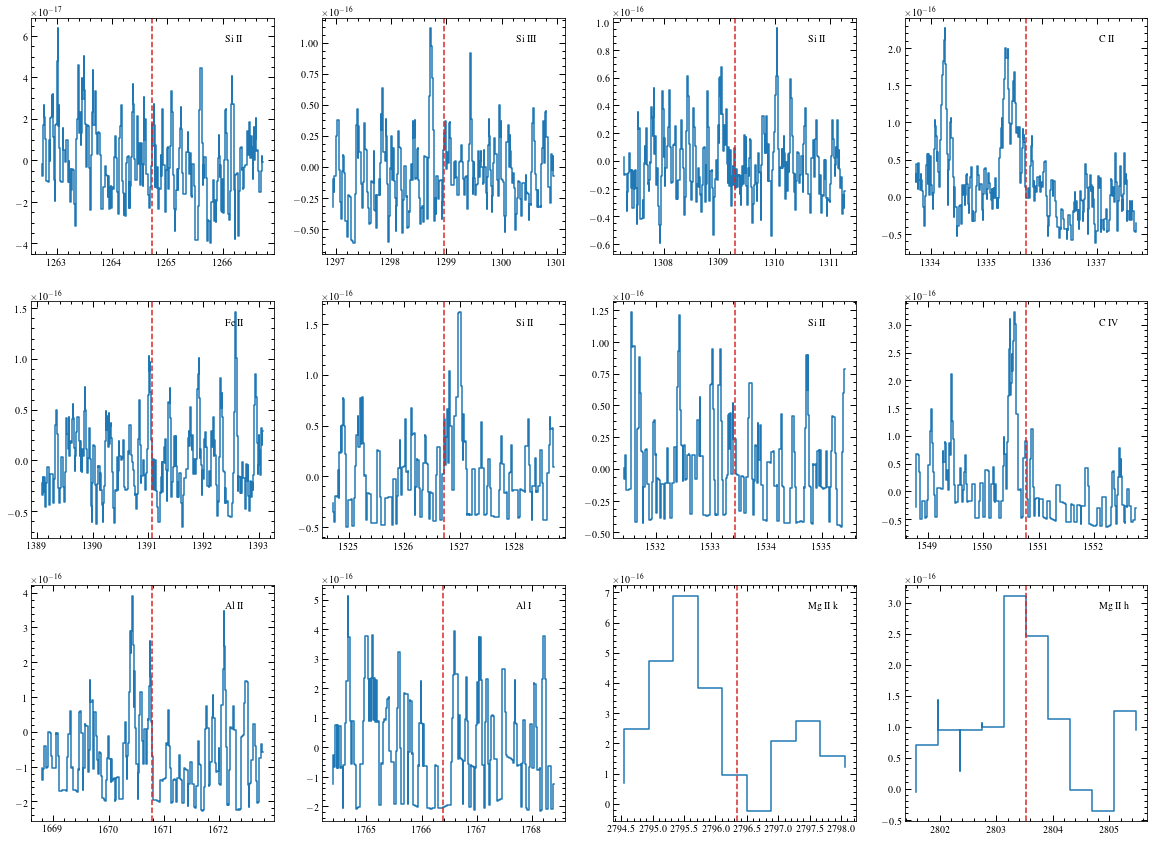

In [19]:
lines = dlines['lambda_angst']
plt.figure(figsize=(20, 20))
for i in range(len(lines)):
    line = lines[i]
    plt.subplot(4,4,i+1)
    mask = (data['WAVELENGTH'] > line-2) & (data['WAVELENGTH'] < line+2)
    flux = convolve(data['FLUX'][mask],Box1DKernel(5))
    plt.step(data['WAVELENGTH'][mask], flux)
    plt.axvline(line, ls='--', c='C3')
    plt.annotate(dlines['Species'][i], (0.8, 0.9), xycoords='axes fraction')
    

First thing to work out is how they calculated the integrated flux, i.e. width of line etc. Doesn't say in paper.

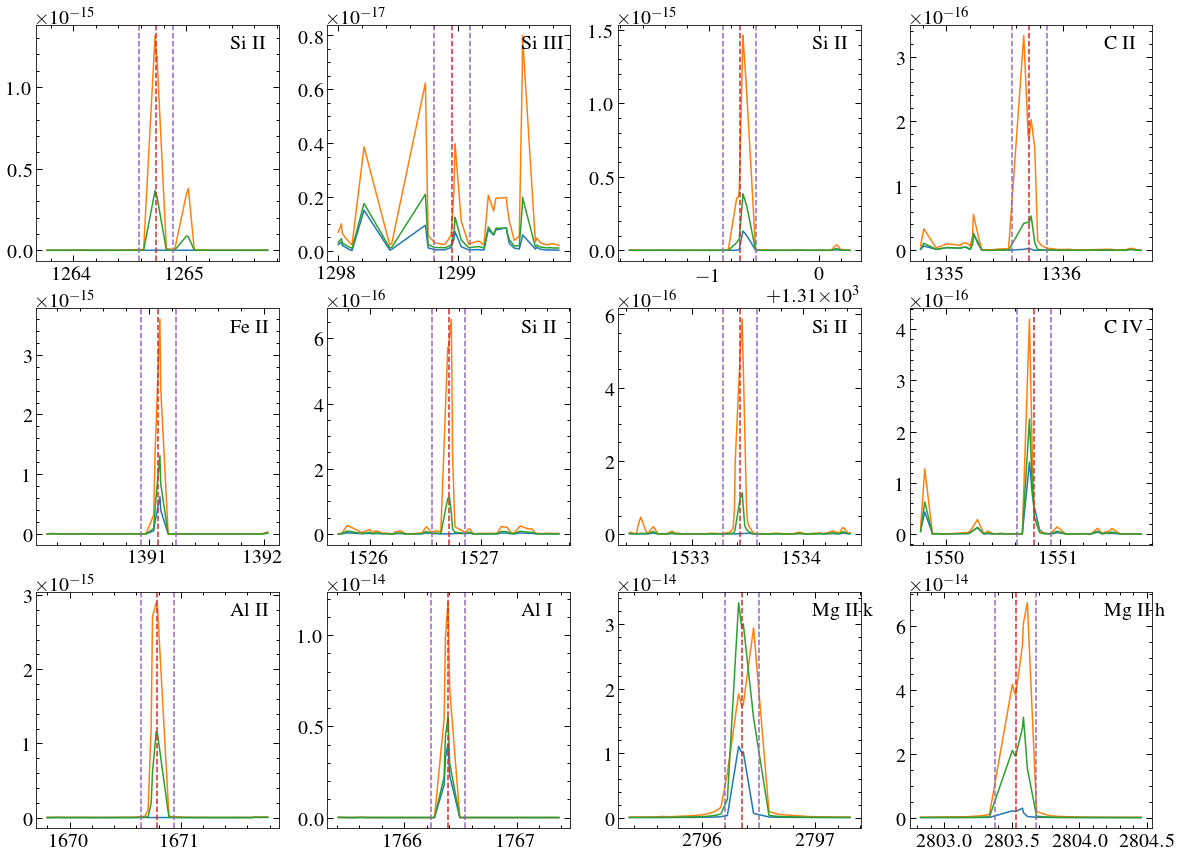

In [42]:
#mw2a, mf2a = np.loadtxt(mpath+mods[0], unpack=True, skiprows=1)
#mw1a, mf1a = np.loadtxt(mpath+mods[1], unpack=True, skiprows=1)
#mw2b, mf2b = np.loadtxt(mpath+mods[2], unpack=True, skiprows=1)
#mf2a, mf1a, mf2b = mf2a*scale, mf1a*scale, mf2b*scale

lines = dlines['lambda_angst']
plt.figure(figsize=(20, 20))
for i in range(len(lines)):
    line = lines[i]
    plt.subplot(4,4,i+1)
    for mw, mf in zip([mw2a, mw1a, mw2b], [mf2a, mf1a, mf2b]):
        mask = (mw > line-1) & (mw < line+1)
        plt.plot(mw[mask], mf[mask])
    #mask = (data['WAVELENGTH'] > line-2) & (data['WAVELENGTH'] < line+2)
    #plt.step(data['WAVELENGTH'][mask], data['FLUX'][mask])
    plt.axvline(line, ls='--', c='C3')
    plt.axvline(line+0.15, ls='--', c='C4')
    plt.axvline(line-0.15, ls='--', c='C4')
    
    plt.annotate(dlines['Species'][i], (0.8, 0.9), xycoords='axes fraction')
    
    

Looks like 0.3 A? But ours will be broader, may have to fit them (gulp).

In [43]:
lines = dlines['lambda_angst']
plt.figure(figsize=(20, 20))
for i in range(len(lines)):
    line = lines[i]
    #plt.subplot(4,4,i+1)
    strengths = []
    for mw, mf in zip([mw1a, mw2a, mw2b], [mf1a, mf2a, mf2b]):
        mask = (mw > line-0.15) & (mw < line+0.15)
        #plt.plot(mw[mask], mf[mask])
        strengths.append(np.trapz(mf[mask], mw[mask]))
    print(dlines['Species'][i], line, [st.value/1e-18 for st in strengths])
    #mask = (data['WAVELENGTH'] > line-2) & (data['WAVELENGTH'] < line+2)
    #plt.step(data['WAVELENGTH'][mask], data['FLUX'][mask])
    #plt.axvline(line, ls='--', c='C3')
    #plt.axvline(line+0.15, ls='--', c='C4')
    #plt.axvline(line-0.15, ls='--', c='C4')
    
   # plt.annotate(dlines['Species'][i], (0.8, 0.9), xycoords='axes fraction')
    

Si II 1264.73 [137.14071198720458, 0.07959674326199537, 38.00526324455754]
Si III 1298.95 [0.28079167178330205, 0.04813783768081047, 0.09836690989246692]
Si II 1309.28 [139.9956186435817, 10.464604971198082, 35.06623145200743]
C II 1335.71 [22.693518612310417, 0.18962773181619463, 3.9984321440887]
Fe II 1391.08 [225.27475040200176, 37.343144344951476, 77.70388438412277]
Si II 1526.71 [46.088677974333095, 0.10849250443267701, 7.4471311961166275]
Si II 1533.43 [41.45460338365288, 0.19422283339782756, 6.7736749187673295]
C IV 1550.77 [22.90652985851743, 9.844182325206972, 13.024174962119393]
Al II 1670.79 [317.9399048723638, 0.045548328880552845, 109.07578101162157]
Al I 1766.39 [1031.748176562304, 342.5414316926617, 447.8763135995567]
Mg II k 2796.35 [4174.507070933209, 1487.2045453265262, 5142.590937793106]
Mg II h 2803.53 [5549.1233532056585, 213.56195470145386, 2563.9465194467507]


<Figure size 1440x1440 with 0 Axes>

In [44]:
plt.figure(figsize=(20, 20))
for i in range(len(lines)):
    line = lines[i]
    #plt.subplot(4,4,i+1)
    strengths = []
    for mw, mf, mint in zip([mw1a, mw2a, mw2b], [mf1a, mf2a, mf2b], [dlines['Model_1A'], dlines['Model_2A'], dlines['Model_2B']]):
        mask = (mw > line-0.15) & (mw < line+0.15)
        #plt.plot(mw[mask], mf[mask])
        strengths.append(np.trapz(mf[mask], mw[mask])/mint[i])
    print(dlines['Species'][i], line, [st.value for st in strengths])


Si II 1264.73 [1.2373970223513902, 0.6633061938499615, 1.55440749466493]
Si III 1298.95 [0.968247144080352, 0.9627567536162094, 0.9836690989246692]
Si II 1309.28 [1.3579941666852429, 1.322958909127444, 1.3445640894174629]
C II 1335.71 [0.6200414921396288, 1.0534873989788591, 0.7377181077654428]
Fe II 1391.08 [1.069071518612385, 1.0128327731204632, 1.0232273424298495]
Si II 1526.71 [1.040611378964396, 1.205472271474189, 1.2579613506953764]
Si II 1533.43 [0.8696161817422462, 0.9711141669891379, 0.9760338499664738]
C IV 1550.77 [1.3379982393993826, 1.1803575929504764, 1.3249415017415453]
Al II 1670.79 [1.0251496255638224, 0.41407571709593494, 1.0778239230397388]
Al I 1766.39 [2.190873753131684, 2.2565311705708937, 2.834660212655422]
Mg II k 2796.35 [0.6033039046585199, 1.1605729065165173, 0.6214844227147006]
Mg II h 2803.53 [0.4911897923670023, 0.7441442374349415, 0.578385116750227]


<Figure size 1440x1440 with 0 Axes>

Ok so it varies by line, think I do need to fit the lines. Good news is it looks like there's a firm rv. https://ui.adsabs.harvard.edu/abs/2014MNRAS.439.3094B/abstract has v = 6 km s$^{-1}$

In [23]:
c = const.c.value

In [24]:
#line*(1.0-(delv/c)
dv = 6000.

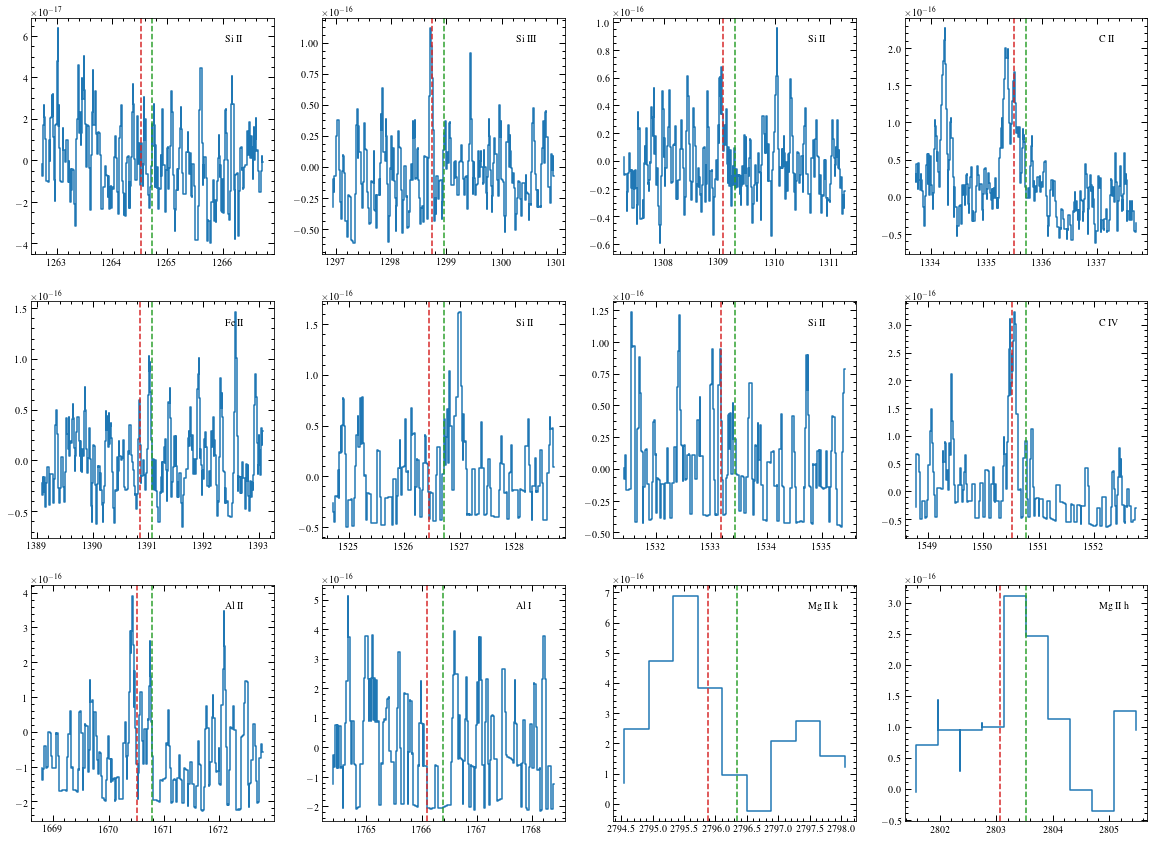

In [25]:
lines = dlines['lambda_angst']
plt.figure(figsize=(20, 20))
for i in range(len(lines)):
    line = lines[i]
    plt.subplot(4,4,i+1)
    mask = (data['WAVELENGTH'] > line-2) & (data['WAVELENGTH'] < line+2)
    flux = convolve(data['FLUX'][mask],Box1DKernel(5))
    plt.step(data['WAVELENGTH'][mask], flux)
    plt.axvline(line, ls='--', c='C2')
    plt.axvline(line*(1.0-(50000/c)), ls='--', c='C3')
    plt.annotate(dlines['Species'][i], (0.8, 0.9), xycoords='axes fraction')
    

So it's not 6... 60 seems a reasonable starting point..

In [26]:
from astropy.modeling import models, fitting

In [27]:
fitter = fitting.LevMarLSQFitter()

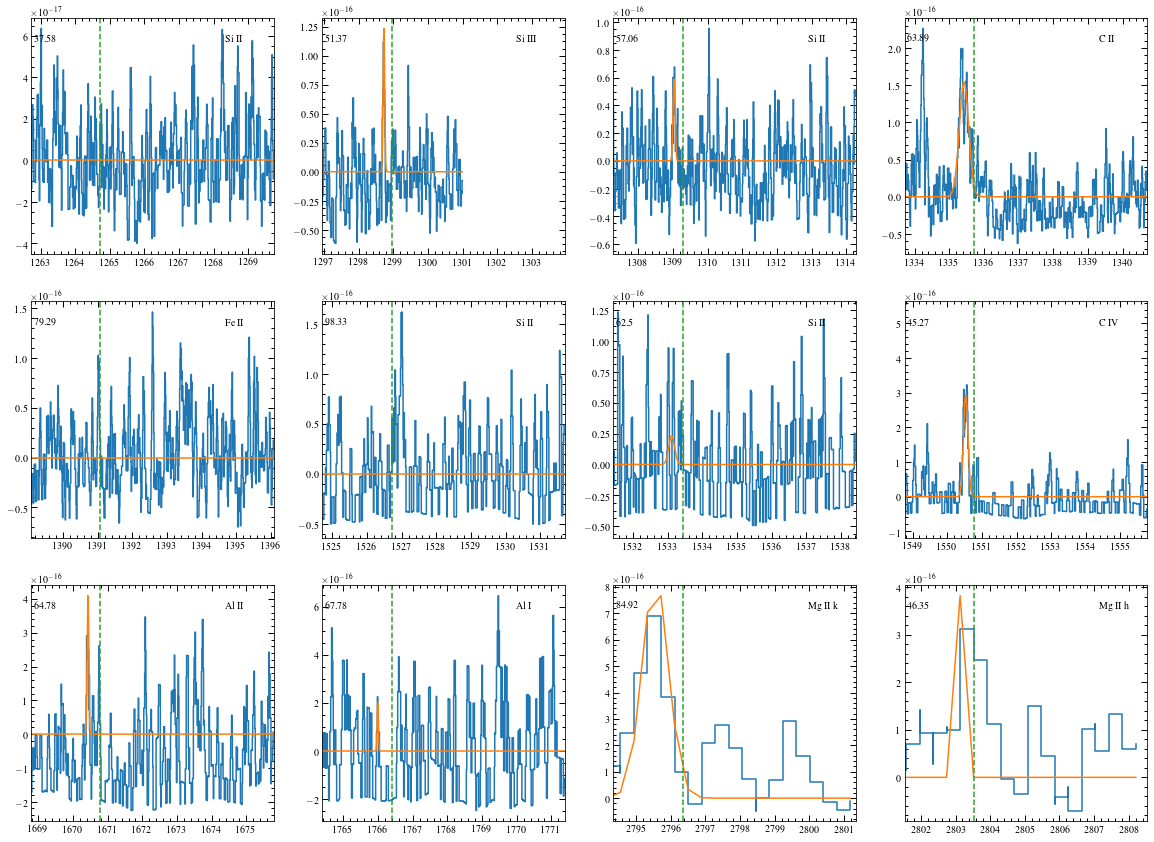

In [28]:
lines = dlines['lambda_angst']
delv=60000.
fluxes=[]
flux_tight = []
plt.figure(figsize=(20, 20))
for i in range(len(lines)):
    line = lines[i]
    plt.subplot(4,4,i+1)
    mask = (data['WAVELENGTH'] > line-5) & (data['WAVELENGTH'] < line+5)
    w = data['WAVELENGTH'][mask]
    f = data['FLUX'][mask]
    gg_init = models.Gaussian1D(4e-16, line*(1.0-(delv/c)), 0.1) #set up an intial gaussian absorption line
    gg_fit = fitter(gg_init, w, f)
    dv=c*(1-(gg_fit.mean/line))
    #print(dv/1000)
    flux = convolve(f,Box1DKernel(5))
    plt.step(w, flux)
    plt.plot(w, gg_fit(w))
    plt.axvline(line, ls='--', c='C2')
    #plt.axvline(line*(1.0-(50000/c)), ls='--', c='C3')
    plt.annotate(dlines['Species'][i], (0.8, 0.9), xycoords='axes fraction')
    plt.annotate(round(dv/1000,2), (0.01, 0.9), xycoords='axes fraction')
    plt.xlim(line-2, line+5)
    fluxes.append(np.trapz(gg_fit(w), w))
    mask = (w > gg_fit.mean - 3*gg_fit.stddev) & (w < gg_fit.mean + 3*gg_fit.stddev)
    flux_tight.append(np.trapz(gg_fit(w[mask]), w[mask]))
    

    

That worked ... way better than I expected it to... Looks like 60 was a reasonable guess for the dv?

Let's smooth them out a bit more, see if I get a better line detection.

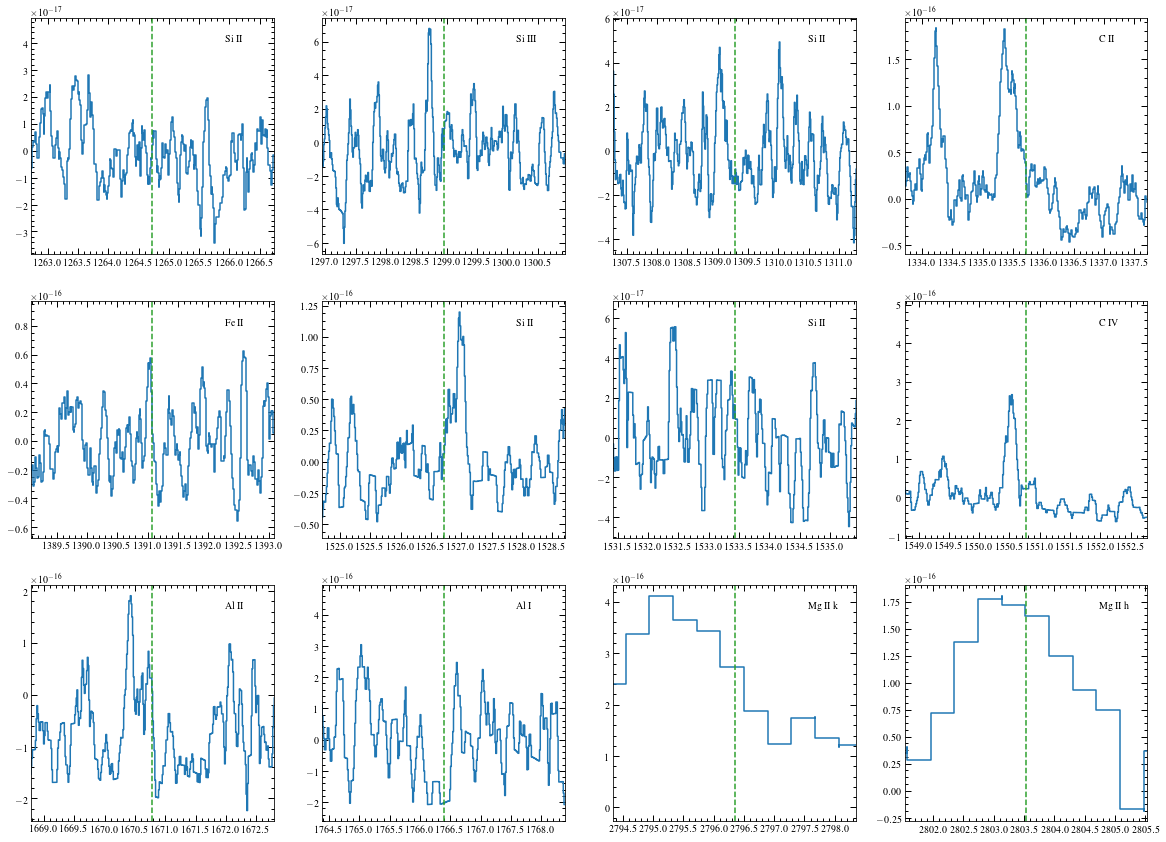

In [29]:
lines = dlines['lambda_angst']
delv=60000.
plt.figure(figsize=(20, 20))
for i in range(len(lines)):
    line = lines[i]
    plt.subplot(4,4,i+1)
    mask = (data['WAVELENGTH'] > line-5) & (data['WAVELENGTH'] < line+5)
    w = data['WAVELENGTH'][mask]
    f = data['FLUX'][mask]
    #gg_init = models.Gaussian1D(4e-16, line*(1.0-(delv/c)), 0.1) #set up an intial gaussian absorption line
    #gg_fit = fitter(gg_init, w, f)
    #dv=c*(1-(gg_fit.mean/line))
    #print(dv/1000)
    flux = convolve(f,Box1DKernel(10))
    plt.step(w, flux)
    #plt.plot(w, gg_fit(w))
    plt.axvline(line, ls='--', c='C2')
    #plt.axvline(line*(1.0-(50000/c)), ls='--', c='C3')
    plt.annotate(dlines['Species'][i], (0.8, 0.9), xycoords='axes fraction')
    #plt.annotate(round(dv/1000,2), (0.01, 0.9), xycoords='axes fraction')
    plt.xlim(line-2, line+2)
    
    

So Fe ii 1391 ish is there, don't know why it isn't fitting it? Maybe try other rvs? Or maybe it's just noise.

In [30]:
for i in range(len(lines)):
    print(dlines['Species'][i], lines[i], round(fluxes[i]/1e-18,2))

Si II 1264.73 0.0
Si III 1298.95 7.19
Si II 1309.28 4.56
C II 1335.71 52.29
Fe II 1391.08 0.0
Si II 1526.71 0.0
Si II 1533.43 4.91
C IV 1550.77 48.1
Al II 1670.79 24.04
Al I 1766.39 9.28
Mg II k 2796.35 788.64
Mg II h 2803.53 149.17


In [31]:
# temperatures of maximum ionisation from chinati feii 1391 missing, 4.6 as placeholder
temperatures = [4.5, 4.7, 4.5, 4.5, 4.6, 4.5, 4.5, 5.0,4.5,4.5,4.5, 4.5]
#temperatures = 10**np.array(temperatures)

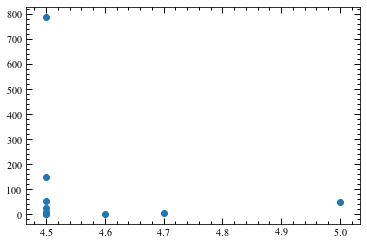

In [32]:
plt.scatter(temperatures, np.array(fluxes)/1e-18)

In [33]:
# [dlines['Model_1A'], dlines['Model_2A'], dlines['Model_2B']]
sv1a = np.array([f/mf for f, mf in zip(fluxes,dlines['Model_1A'])])
sv2a = np.array([f/mf for f, mf in zip(fluxes,dlines['Model_2A'])])
sv2b = np.array([f/mf for f, mf in zip(fluxes,dlines['Model_2B'])])
print(sv1a)

[0.00000000e+00 2.47916780e+01 4.42573747e-02 1.42859601e+00
 0.00000000e+00 0.00000000e+00 1.02968377e-01 2.80954569e+00
 7.75100740e-02 1.97014922e-02 1.13974620e-01 1.32038181e-02]


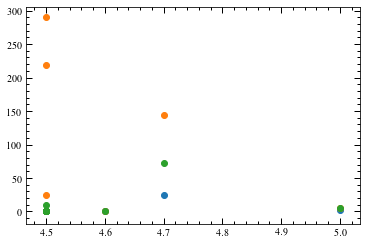

In [34]:
plt.scatter(temperatures, sv1a)
plt.scatter(temperatures, sv2a)
plt.scatter(temperatures, sv2b)
#plt.yscale('log')

So to first approximation,they're good to within 2 oom. Formation temp prehaps not the best plot, although it does show that it's better at high t - could just be upper limits, need to improve the fit. Think plotting against wavelength will look better. Also should check if the P+19 scalings are good, i.e. lyalpha / galex.

Text(0, 0.5, '$F_{\\mathrm{obs}}/F_{\\mathrm{mod}}$')

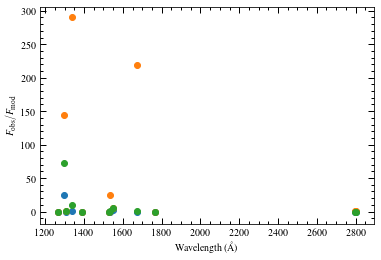

In [35]:
plt.scatter(lines, sv1a, label = ['Model 1A'])
plt.scatter(lines, sv2a, label = ['Model 2A'])
plt.scatter(lines, sv2b, label = ['Model 2B'])
plt.xlabel('Wavelength (\AA)')
plt.ylabel('$F_{\mathrm{obs}}/F_{\mathrm{mod}}$')

In [36]:
print(fluxes)
print(flux_tight)
print(np.array(fluxes)/np.array(flux_tight))


[0.0, 7.189586614604537e-18, 4.562492757885155e-18, 5.2286614057801434e-17, 0.0, 0.0, 4.908502519997037e-18, 4.809942220912919e-17, 2.403897436055466e-17, 9.278023743880986e-18, 7.886371270756444e-16, 1.4916762586260646e-16]
[0.0, 7.142080803905856e-18, 4.534493669325377e-18, 5.213523826171446e-17, 0.0, 0.0, 4.889542444920326e-18, 4.791087107855834e-17, 2.3786713362873756e-17, 9.18674694039975e-18, 7.769364811243092e-16, 0.0]
[       nan 1.00665154 1.00617469 1.00290352        nan        nan
 1.00387768 1.00393546 1.01060512 1.0099357  1.01505998        inf]


/home/david/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/david/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Good, choice of range over which to integrate models is unimportant.

In [37]:
#galex
fuv_width = [1334,1786]
nuv_width = [1771, 2831]

/home/david/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/david/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/home/david/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


(1000, 3000)

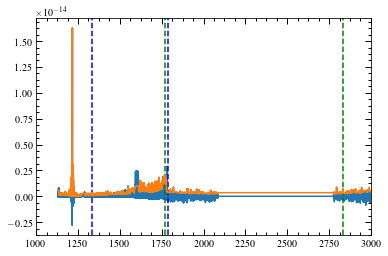

In [38]:
plt.step(data['WAVELENGTH'], data['FLUX'])
[plt.axvline(fuv, ls ='--', c ='b') for fuv in fuv_width]
[plt.axvline(nuv, ls ='--', c ='g') for nuv in nuv_width]
mask = (data['FLUX']/data['ERROR'] > 1)
plt.step(data['WAVELENGTH'][mask], data['FLUX'][mask])
plt.xlim(1000, 3000)

Nuv flux contains most of that gap, which is frustrating. Let's check that first. P+19 only uses upper limits for the fuv but we can still check it.

In [39]:
fuv_mask = (data['WAVELENGTH'] > fuv_width[0]) & (data['WAVELENGTH'] < fuv_width[1])
fuv_flux = np.trapz(data['FLUX'][fuv_mask], data['WAVELENGTH'][fuv_mask])
nuv_mask = (data['WAVELENGTH'] > nuv_width[0]) & (data['WAVELENGTH'] < nuv_width[1])
nuv_flux = np.trapz(data['FLUX'][nuv_mask], data['WAVELENGTH'][nuv_mask])
nuv_flux = np.trapz(data['FLUX'][nuv_mask], data['WAVELENGTH'][nuv_mask])

nuv_mask = (data['WAVELENGTH'] > nuv_width[0]) & (data['WAVELENGTH'] < nuv_width[1])&(data['FLUX']/data['ERROR'] > 1)
nfm = np.trapz(data['FLUX'][nuv_mask], data['WAVELENGTH'][nuv_mask])
#nb P+19 give flux/A, which I assume means they divided it by the bandwidth(?)
print(fuv_flux/(fuv_width[1]-fuv_width[0])) # = -1.2828451197572833e-17
# why are you negative?
#print(np.log10(fuv_flux/(fuv_width[1]-fuv_width[0])))
print(np.log10(nuv_flux/(nuv_width[1]-nuv_width[0])))
#print(nuv_flux)
#print(np.log10(nfm/(nuv_width[1]-nuv_width[0])))

-1.2828451197572833e-17
-17.26744166091669


/home/david/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/home/david/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


Nuv is a little higher than their highest, but error bars abound (do we even detect any lines in that range?) Fuv is ...broke, let's see if I can fix it... could sum fluxes of the emission lines?

Checking that there's nothing interesting in the NUV gap...

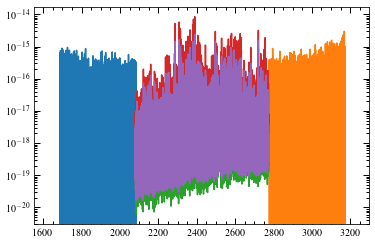

In [40]:
nuvdata = fits.getdata('/home/david/work/muscles/trappist-1/hst/data/ldlm42010_x1dsum.fits',1)
for dt in nuvdata[0:2]:
    plt.plot(dt['WAVELENGTH'], dt['FLUX']) 
for mw, mf in zip([mw2a, mw1a, mw2b], [mf2a, mf1a, mf2b]):
        mask = (mw >2080 ) & (mw < 2775)
        plt.plot(mw[mask], mf[mask])
plt.yscale('log')

Ok that's a lot-only in the h alpha fit, but much weaker than the detected lines. What about the little lines at 2100 ish?

(-1e-17, 1e-17)

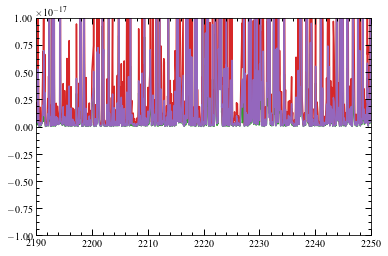

In [41]:
nuvdata = fits.getdata('/home/david/work/muscles/trappist-1/hst/data/ldlm42010_x1dsum.fits',1)
for dt in nuvdata[0:2]:
    plt.step(dt['WAVELENGTH'], dt['FLUX']) 
for mw, mf in zip([mw2a, mw1a, mw2b], [mf2a, mf1a, mf2b]):
        mask = (mw >1800 ) & (mw < 3000)
        plt.plot(mw[mask], mf[mask], zorder=-5)
plt.xlim(2190, 2250)
plt.ylim(-0.1e-16, 0.1e-16)

Non-detection.

Better line identification/fitting - let's get a good rv from the strong lines.

[61019.78175349 63944.96973045 66797.5303561  63436.82746475
 43480.58965943 46044.70624937]
[3301.5867921108074, 3035.5705635807535, 1570.5588335831308, 4119.9783348841265, 1159.3715410776786, 2476.83995645928]
57454.067535597715 62228.30460911954
9159.434589084034


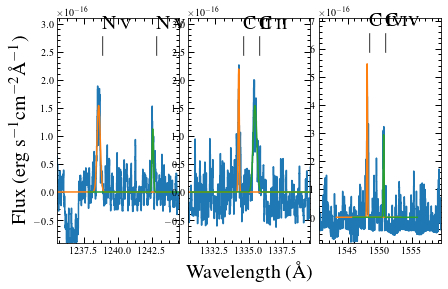

In [42]:
def dv_finder(rest, obs, obs_e): #calculates delta_v and an error
    dv = c*(1.-(obs/rest))
    dv_e = 0.
    if obs_e !=0.:
        dv_e = (abs((c*(1.-((obs+obs_e)/rest))-dv))+abs((c*(1.-((obs-obs_e)/rest)))-dv))/2.
    return dv, dv_e 

def fit_line(line, w, f, guess_dv):
    c = const.c.value
    gg_init = models.Gaussian1D(4e-16, line*(1.0-(guess_dv/c)), 0.1) #set up an intial gaussian absorption line
    gg_fit = fitter(gg_init, w, f)
    fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
    #dv=c*(1-(gg_fit.mean/line))
    dv, dv_e = dv_finder(line, gg_fit.mean, fit_e[1])
    plt.plot(w, gg_fit(w))
    return dv, dv_e

fitter = fitting.LevMarLSQFitter()
guess_dv = 60000.

dvs = []
dves = []
data = Table.read('../combined/TRAPPIST-1_hst+phoenix_v1.ecsv')
w, f, e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
f1, e1 = convolve(f,Box1DKernel(5)), convolve(e,Box1DKernel(5))
plt.subplots_adjust(top = 0.93, right = 0.99, left = 0.1, bottom = 0.15, wspace = 0.07)

plt.subplot(131)
plt.step(w, f1)
plt.ylim(-0.9e-16,3.1e-16)
plt.xlim(1235.5, 1244.5)
[plt.annotate('N\,{\sc v}\n$|$',(n, 2.5e-16),size=20) for n in n_v]
plt.ylabel('Flux (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)', size=20)
for line in n_v:
    mask = (w > line -5) & (w < line +5)
    dv, dve = fit_line(line, w[mask], f[mask], guess_dv)
    dvs.append(dv)
    dves.append(dve)



plt.subplot(132)
plt.step(w, f1)
plt.ylim(-0.9e-16, 3.1e-16)
plt.xlim(1330.5, 1339.5)
[plt.annotate('C\,{\sc ii}\n$|$',(c, 2.5e-16),size=20) for c in c_ii]
plt.xlabel('Wavelength (\AA)', size=20)
for line in c_ii:
    mask = (w > line -5) & (w < line +5)
    dv, dve = fit_line(line, w[mask], f[mask], guess_dv)
    dvs.append(dv)
    dves.append(dve)

plt.subplot(133)
plt.step(w, f1)
plt.ylim(-0.9e-16, 7.1e-16)
plt.xlim(1540.5, 1559.5)
[plt.annotate('C\,{\sc iv}\n$|$',(c, 6e-16),size=20) for c in c_iv]
for line in c_iv:
    mask = (w > line -5) & (w < line +5)
    dv, dve = fit_line(line, w[mask], f[mask], guess_dv)
    dvs.append(dv)
    dves.append(dve)
    
dvs = np.array(dvs)
print(dvs)
print(dves)
print(np.mean(dvs), np.median(dvs))
print(np.std(dvs))

Error estimates on the line fits- std of the surrounding area?

[0.0, 6.336070318930749e-18, 4.67273093310446e-18, 5.2337581112128556e-17, 0.0, 0.0, 4.830507478078484e-18, 4.786008771069504e-17, 2.1915552152276846e-17, 5.980236021967641e-18, 8.027524082006657e-16, 3.477438140128991e-16]
[0.00000000e+00 5.88830830e-17 4.44487824e-17 3.17758710e-17
 0.00000000e+00 0.00000000e+00 4.20174343e-17 2.25904414e-17
 1.44907957e-17 2.57280321e-16 5.91035463e-16 2.78422296e-16]
[       nan 0.10760426 0.10512619 1.64708565        nan        nan
 0.11496436 2.11859905 1.51237742 0.02324405 1.35821361 1.24897976]


/home/david/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


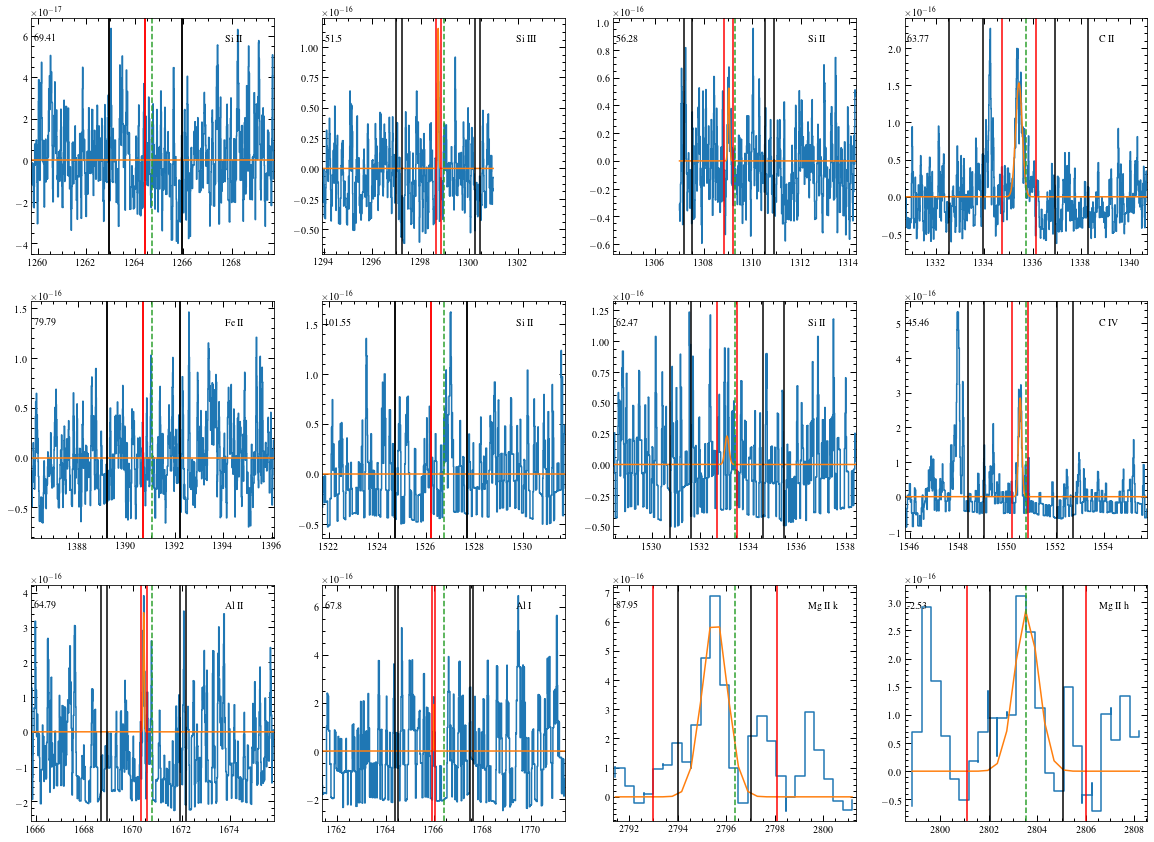

In [43]:
lines = dlines['lambda_angst']
delv=60000.
fluxes=[]
fe =[]
flux_tight = []
plt.figure(figsize=(20, 20))
for i in range(len(lines)):
    line = lines[i]
    plt.subplot(4,4,i+1)
    mask = (data['WAVELENGTH'] > line-5) & (data['WAVELENGTH'] < line+5)
    w = data['WAVELENGTH'][mask]
    f = data['FLUX'][mask]
    flux = convolve(f,Box1DKernel(5))
    gg_init = models.Gaussian1D(4e-16, line*(1.0-(delv/c)), 0.1) #set up an intial gaussian absorption line
    gg_fit = fitter(gg_init, w, flux)
    dv=c*(1-(gg_fit.mean/line))
    #print(dv/1000)
    
    plt.step(w, flux)
    plt.plot(w, gg_fit(w))
    plt.axvline(line, ls='--', c='C2')
    #plt.axvline(line*(1.0-(50000/c)), ls='--', c='C3')
    plt.annotate(dlines['Species'][i], (0.8, 0.9), xycoords='axes fraction')
    plt.annotate(round(dv/1000,2), (0.01, 0.9), xycoords='axes fraction')
    plt.xlim(line-5, line+5)
    fluxes.append(np.trapz(gg_fit(w), w))
    mask = (w > gg_fit.mean - 5*gg_fit.stddev) & (w < gg_fit.mean + 5*gg_fit.stddev)
    [plt.axvline(sideline, c='r') for sideline in [gg_fit.mean - 5*gg_fit.stddev, gg_fit.mean + 5*gg_fit.stddev]]
    flux_tight.append(np.trapz(gg_fit(w[mask]), w[mask]))
    bg_lines = [gg_fit.mean-(1.5+10*gg_fit.stddev), gg_fit.mean-1.5,gg_fit.mean+1.5, gg_fit.mean+(1.5+10*gg_fit.stddev)]
    [plt.axvline(bgline, c='k') for bgline in bg_lines]
    bgmask = (w > bg_lines[0]) & (w < bg_lines [1]) | (w > bg_lines[2]) & (w < bg_lines [3])
    fe.append(np.trapz(flux[bgmask], w[bgmask])/2.)

print(flux_tight)
print(abs(np.array(fe)))
print(np.array(flux_tight/abs(np.array((fe)))))

    

    

In [44]:
dlines.dtype.names

('Species', 'lambda_angst', 'Model_1A', 'Model_2A', 'Model_2B', 'f0')

In [45]:
detected = np.array([1,2,3,7,8,10,11], dtype=int)
d_flux = np.array(flux_tight)[detected]
d_wav = lines[detected]
l1a = dlines['Model_1A'][detected]
l2a = dlines['Model_2A'][detected]
l2b = dlines['Model_2B'][detected]
det_names = [name+' '+str(wav) for name, wav in zip(dlines['Species'][detected], d_wav)]

In [46]:
sv1a = np.array([f/mf for f, mf in zip(d_flux,l1a)])
sv2a = np.array([f/mf for f, mf in zip(d_flux,l2a)])
sv2b = np.array([f/mf for f, mf in zip(d_flux,l2b)])

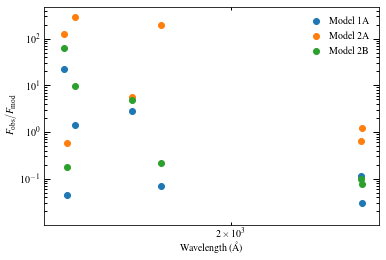

In [47]:
plt.scatter(d_wav, sv1a, label = 'Model 1A')
plt.scatter(d_wav, sv2a, label = 'Model 2A')
plt.scatter(d_wav, sv2b, label = 'Model 2B')
plt.xlabel('Wavelength (\AA)')
plt.ylabel('$F_{\mathrm{obs}}/F_{\mathrm{mod}}$')
plt.legend()
plt.xscale('log')
plt.yscale('log')

/home/david/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


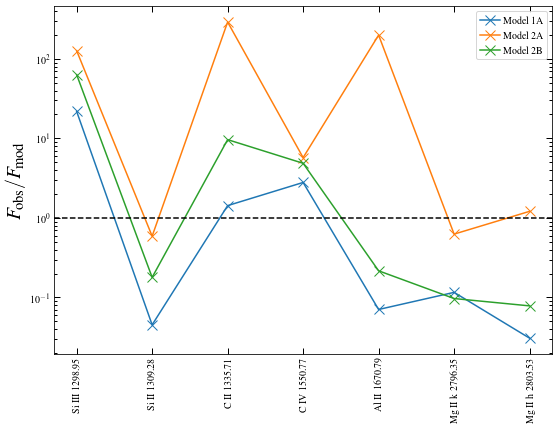

In [48]:
plt.figure(figsize = (8,7))
plt.subplots_adjust(top=0.99, right =0.99, bottom = 0.3)
xaxis = np.arange(len(det_names))
#plt.scatter(xaxis, sv1a, label = 'Model 1A')
plt.plot(xaxis, sv1a, marker='x', markersize=10, label = 'Model 1A' )
plt.plot(xaxis, sv2a, marker='x', markersize=10, label = 'Model 2A' )
plt.plot(xaxis, sv2b, marker='x', markersize=10, label = 'Model 2B' )
#plt.xlabel('Line')
plt.ylabel('$F_{\mathrm{obs}}/F_{\mathrm{mod}}$', size=20)
plt.legend(frameon=True)
plt.yscale('log')
plt.xticks(xaxis, det_names, rotation='vertical')
plt.axhline(1, c='k', ls ='--')
plt.axes().xaxis.set_tick_params(which='minor', bottom=False, top=False)
plt.savefig('lines_v_mod.pdf', dpi=150)
plt.savefig('lines_v_mod.png', dpi=150)

Measuring fluxes of the strong detected lines (Nv, Cii, CV)

[[0.6       ]
 [0.75      ]
 [0.3       ]
 [0.46666667]
 [0.6       ]
 [0.45      ]]
nv 1238.821 4.345793895746563e-17 [7.00087473e-18]
nv 1242.804 2.309085142155663e-17 [8.75109341e-18]
cii 1334.532 3.2044370920724874e-17 [5.12311908e-18]
cii 1335.708 5.3720709976076803e-17 [7.96929635e-18]
civ 1548.202 1.0838314070065273e-16 [8.99234935e-18]
civ 1550.774 4.385749275084124e-17 [6.74426202e-18]


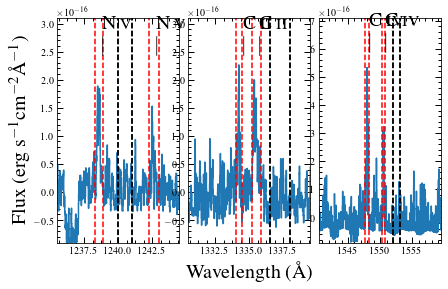

In [49]:
c_ii = [1334.532 ,1335.708]
n_v = [1238.821,1242.804]
c_iv = [1548.202, 1550.774]

fluxes =[]
errors = []

line_names = ['nv', 'nv', 'cii', 'cii', 'civ', 'civ']
lines = [1238.821,1242.804,1334.532 ,1335.708,1548.202, 1550.774]
line_edges = [[1238.3,1238.9], [1242.25,1243.],[1334.,1334.45],[1335.2,1335.9],[1547.6,1548.2],[1550.3,1550.75]]
line_width = np.diff(line_edges)

bgr = [[1240.,1241.],[1240.,1241.],[1336.5, 1338.],[1336.5, 1338.],[1552., 1553.],[1552., 1553.]]
bgr_width = np.diff(bgr)
e_scale = line_width/bgr_width
print(e_scale)

data = Table.read('../combined/TRAPPIST-1_hst+phoenix_v1.ecsv')
w, f, e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
f1, e1 = convolve(f,Box1DKernel(5)), convolve(e,Box1DKernel(5))
plt.subplots_adjust(top = 0.93, right = 0.99, left = 0.1, bottom = 0.15, wspace = 0.07)

plt.subplot(131)
plt.step(w, f1)
plt.ylim(-0.9e-16,3.1e-16)
plt.xlim(1235.5, 1244.5)
[plt.annotate('N\,{\sc v}\n$|$',(n, 2.5e-16),size=20) for n in n_v]
for line_e in line_edges:
    [plt.axvline(line, ls ='--', c='r') for line in line_e]
    
for bgrs in bgr:
    [plt.axvline(line, ls ='--', c='k') for line in bgrs]

plt.ylabel('Flux (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)', size=20)


plt.subplot(132)
plt.step(w, f1)
plt.ylim(-0.9e-16, 3.1e-16)
plt.xlim(1330.5, 1339.5)
[plt.annotate('C\,{\sc ii}\n$|$',(c, 2.5e-16),size=20) for c in c_ii]
plt.xlabel('Wavelength (\AA)', size=20)
for line_e in line_edges:
    [plt.axvline(line, ls ='--', c='r') for line in line_e]

for line_e in bgr:
    [plt.axvline(line, ls ='--', c='k') for line in line_e]

    
plt.subplot(133)
plt.step(w, f1)
plt.ylim(-0.9e-16, 7.1e-16)
plt.xlim(1540.5, 1559.5)
[plt.annotate('C\,{\sc iv}\n$|$',(c, 6e-16),size=20) for c in c_iv]
for line_e in line_edges:
    [plt.axvline(line, ls ='--', c='r') for line in line_e]

for line_e in bgr:
    [plt.axvline(line, ls ='--', c='k') for line in line_e]

    
for i in range(len(lines)):
    line_mask = (w > line_edges[i][0]) & (w < line_edges[i][1])
    int_flux = np.trapz(f[line_mask], w[line_mask])
    bg_mask = (w > bgr[i][0]) & (w < bgr[i][1])
    bg_flux = np.trapz(f[bg_mask], w[bg_mask])*e_scale[i]
    print(line_names[i], lines[i], int_flux, abs(bg_flux))
    fluxes.append(int_flux)
    errors.append(abs(bg_flux))

So results look like:  
name line(A) flux(e-17 erg s-1 cm-2) error (e-17 erg s-1 cm-2)    
nv 1238.821 4.35 0.7  
nv 1242.804 2.31 0.88.  
cii 1334.532 3.20 0.51  
cii 1335.708 5.37 0.80  
civ 1548.202 10.8 0.90  
civ 1550.774 4.39 0.67  



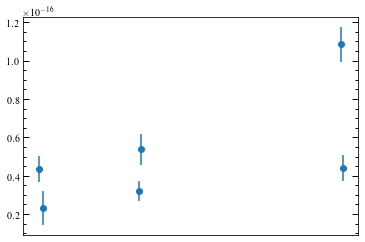

In [50]:
plt.errorbar(lines, fluxes, yerr =errors, ls = 'none', marker='o')
plt.xscale('log')
#plt.xticks(lines, line_names)

Some more lines.

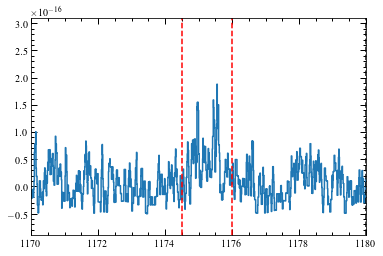

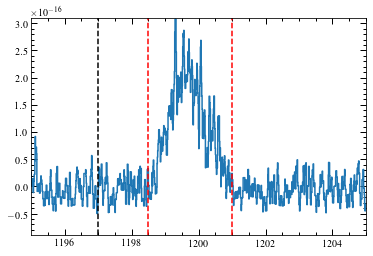

TimeoutError: Lock error: Matplotlib failed to acquire the following lock file:
    /home/david/.cache/matplotlib/tex.cache/fad6dcaf5985af73ce11c290f257d997.tex.matplotlib-lock
This maybe due to another process holding this lock file.  If you are sure no
other Matplotlib process is running, remove this file and try again.

<Figure size 432x288 with 1 Axes>

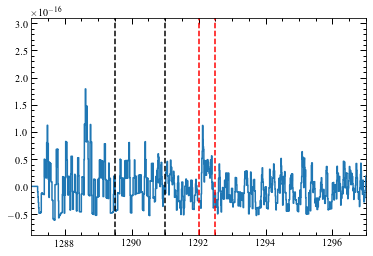

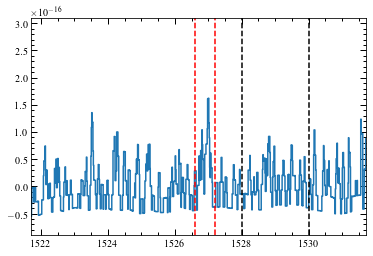

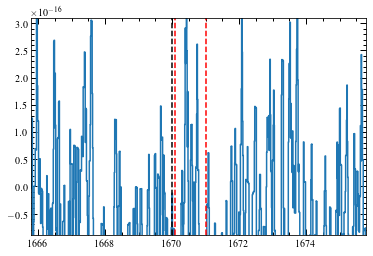

cii 1175 6.044108657965425e-17 [2.12517529e-18]
feii 1200 2.773107457338672e-16 [1.08578144e-17]
ci 1288 1.30991815084263e-17 [1.43775221e-18]
feii 1292 9.358019568490401e-18 [1.43775221e-18]
sii 1526.71 2.2222328500382208e-17 [2.84944948e-18]
alii 1670.79 -3.936946308572138e-17 [0.]


In [51]:
lines = [1175, 1200, 1288, 1292, 1526.71, 1670.79]
line_names = ['cii', 'feii', 'ci', 'feii','sii','alii']

line_edges = [[1174.5,1176],[1198.5,1201.],[1288.5, 1289.],[1292, 1292.5],[1526.6, 1527.2],[1670.1, 1671]]
bgr = [[1180,1183],[1192,1197], [1289.5, 1291],[1289.5, 1291],[1528,1530],[1688,1670.]]
line_width = np.diff(line_edges)
bgr_width = np.diff(bgr)
e_scale = line_width/bgr_width


fluxes = []
errors = []
for i in range(len(lines)):
    line = lines[i]
    plt.step(w, f1)
    plt.xlim(line-5, line+5)
    plt.ylim(-0.9e-16,3.1e-16)
    [plt.axvline(l, ls ='--', c='r') for l in line_edges[i]]
    [plt.axvline(l, ls ='--', c='k') for l in bgr[i]]
    plt.show()

for i in range(len(lines)):
    line_mask = (w > line_edges[i][0]) & (w < line_edges[i][1])
    int_flux = np.trapz(f[line_mask], w[line_mask])
    bg_mask = (w > bgr[i][0]) & (w < bgr[i][1])
    bg_flux = np.trapz(f[bg_mask], w[bg_mask])*e_scale[i]
    print(line_names[i], lines[i], int_flux, abs(bg_flux))
    fluxes.append(int_flux)
    errors.append(abs(bg_flux))

name line(A) flux(e-17 erg s-1 cm-2) error (e-17 erg s-1 cm-2)  
cii 1175 6.0 0.2  
feii 1200 27.7 1.1  
ci 1288 1.3 0.1  
feii 1292 <1  
sii 1526.71 2.2 0.3  

Let's make a better comparison with P+19. Need to do a good meausrement of Mg ii first...

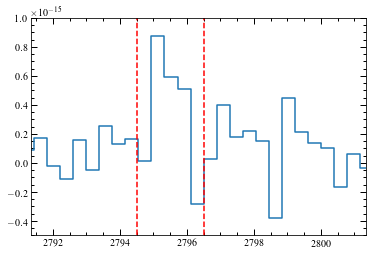

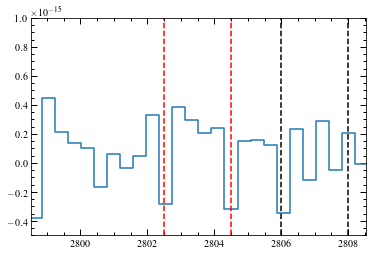

mgii 2796.35 7.090400536637659e-16 [6.47354371e-17]
mgii 2803.53 3.3460853561765107e-16 [7.72608769e-17]


In [52]:
lines = [2796.35, 2803.53]
line_names = ['mgii', 'mgii']

line_edges = [[2794.5,2796.5], [2802.5,2804.5]]
bgr = [[2806, 2810], [2806, 2808]]
line_width = np.diff(line_edges)
bgr_width = np.diff(bgr)
e_scale = line_width/bgr_width


fluxes = []
errors = []
for i in range(len(lines)):
    line = lines[i]
    plt.step(w, f)
    plt.xlim(line-5, line+5)
    plt.ylim(-5e-16,10e-16)
    [plt.axvline(l, ls ='--', c='r') for l in line_edges[i]]
    [plt.axvline(l, ls ='--', c='k') for l in bgr[i]]
    plt.show()

for i in range(len(lines)):
    line_mask = (w > line_edges[i][0]) & (w < line_edges[i][1])
    int_flux = np.trapz(f[line_mask], w[line_mask])
    bg_mask = (w > bgr[i][0]) & (w < bgr[i][1])
    bg_flux = np.trapz(f[bg_mask], w[bg_mask])*e_scale[i]
    print(line_names[i], lines[i], int_flux, abs(bg_flux))
    fluxes.append(int_flux)
    errors.append(abs(bg_flux))

name line(A) flux(e-17 erg s-1 cm-2) error (e-17 erg s-1 cm-2)  
mgii 2796.35 71.0 6.5  
mgii 2803.53 33 6.0

Ok, now for the good comparison. One big table first...

name line(A) flux(e-17 erg s-1 cm-2) error (e-17 erg s-1 cm-2)  
cii 1175 6.0 0.2  
feii 1200 27.7 1.1  
nv 1238.821 4.35 0.7    
nv 1242.804 2.31 0.88  
ci 1288 1.3 0.1  
feii 1292 <1  
cii 1334.532 3.20 0.51  
cii 1335.708 5.37 0.80  
sii 1526.71 2.2 0.3  
civ 1548.202 10.8 0.90  
civ 1550.774 4.39 0.67  
mgii 2796.35 71.0 6.5  
mgii 2803.53 33 6.0  

In [53]:
mlines = np.genfromtxt('phoenix_model_lines.txt', delimiter='\t', names=True, dtype=None,encoding=None)

In [54]:
print(mlines['Species'])
print(mlines['lambda_angst'])

['Si II' 'Si III' 'O I' 'O I' 'O I' 'Si II' 'C II' 'Fe II' 'Si II' 'Si II'
 'C IV' 'Al II' 'Al I' 'Mg II k' 'Mg II h' 'Ca II K' 'Ca II H']
[1264.73 1298.95 1302.17 1304.86 1306.03 1309.28 1335.71 1391.08 1526.71
 1533.43 1550.77 1670.79 1766.39 2796.35 2803.53 3934.78 3969.59]


In [55]:
dnames = np.array(['C II',  'Si II', 'C IV', 'Mg II k', 'Mg II h'])
dlines = [1335.71, 1526.71, 1550.77, 2796.35, 2803.53]
dflux = np.array([3.2+5.37,2.2,10.8+4.39, 71.0, 33.0])
derror = np.array([(0.51**2+0.80**2)**0.5, 0.3,(0.9**2+0.67**2)**0.5,6.5, 6.0])
#convert to 10-18
dflux *=10
derror *=10
eper = derror/dflux #saves typing

In [56]:
mdet = mlines[np.array([6,8,10,13,14])]

In [57]:
mdet

array([('C II', 1335.71,    36.6 , 1.80000e-01, 5.42000e+00, False),
       ('Si II', 1526.71,    44.29, 9.00000e-02, 5.92000e+00, False),
       ('C IV', 1550.77,    17.12, 8.34000e+00, 9.83000e+00, False),
       ('Mg II k', 2796.35,  6919.41, 1.28144e+03, 8.27469e+03, False),
       ('Mg II h', 2803.53, 11297.31, 2.86990e+02, 4.43294e+03, False)],
      dtype=[('Species', '<U7'), ('lambda_angst', '<f8'), ('Model_1A', '<f8'), ('Model_2A', '<f8'), ('Model_2B', '<f8'), ('f0', '?')])

In [58]:
r1a = mdet['Model_1A']/dflux
e1a = eper*r1a
r2a = mdet['Model_2A']/dflux
e2a = eper*r2a
r2b = mdet['Model_2B']/dflux
e2b = eper*r2b


/home/david/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


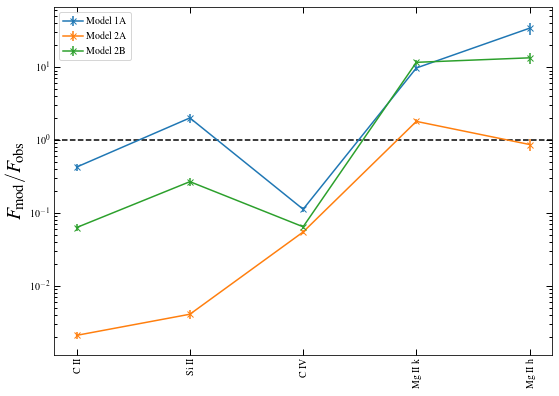

In [59]:
plt.figure(figsize = (8,7))
plt.subplots_adjust(top=0.99, right =0.99, bottom = 0.3)
xaxis = np.arange(len(dnames))
plt.errorbar(xaxis, r1a, yerr=e1a, marker='x', label = 'Model 1A')
plt.errorbar(xaxis, r2a, yerr=e2a, marker='x', label = 'Model 2A')
plt.errorbar(xaxis, r2b, yerr=e2b, marker='x', label = 'Model 2B')
#plt.xlabel('Line')
plt.ylabel('$F_{\mathrm{mod}}/F_{\mathrm{obs}}$', size=20)
plt.legend(frameon=True)
plt.yscale('log')
plt.xticks(xaxis, dnames, rotation='vertical')
plt.axhline(1, c='k', ls ='--')
plt.axes().xaxis.set_tick_params(which='minor', bottom=False, top=False)
plt.savefig('lines_v_mod.pdf', dpi=150, overwrite=True)
plt.savefig('lines_v_mod.png', dpi=150, overwrite=True)

Let's make some nice plots of lines!

In [4]:
data = Table.read('../combined/TRAPPIST-1_hst+phoenix_v1.ecsv')

In [5]:
#name line(A) flux(e-17 erg s-1 cm-2) error (e-17 erg s-1 cm-2) 
species = np.array(['ciii', 'feii', 'siiii','nv', 'nv', 'ci', 'feii', 'cii', 'cii', 'feii', 'civ', 'civ', 'mgii', 'mgii'] )
lines = np.array([1175.5, 1200, 1206.53,1238.821, 1242.804,1288.8, 1292.5,1334.532, 1335.708 ,1527.3 ,1548.202,1550.774 ,2796.35 ,2803.53])
fluxes = np.array([6.0, 27.7, 4.35,2.31,1.3,-1,3.20,5.37,2.2, 10.8,4.39, 71.0, 33])
flux_errors = np.array([0.2, 1.1, 0.7, 0.88, 0.1, 0.0, 0.51, 0.80, 0.3, 0.90, 0.67, 6.5,6.0])

#ciii_1175 = [1174.93,1175.26,1175.59,1175.71,1175.99,1176.37]
ciii_1175 = [1174.93,1175.26,1175.59,1175.71,1175.99]
#feii_1200 =[1197.434,1197.499,1198.051,1198.194,1198.368,1198.398,1198.660,1198.924,1199.231,1199.681,1200.889,1201.415,1201.506,1201.548,1201.651,1201.960,1202.452,1202.580]
feii_1200 =[1198.924,1199.231,1199.681,1200.889]
siiii_1206 = [1206.51, 1206.53]
nv_1240 = [1238.821, 1242.804]
#ci_1288 = [1287.609,1287.809,1288.038,1288.040,1288.422,1288.711,1288.918,1289.893,1289.975]
ci_1288 = [1288.711,1288.918]
#feii_1292 = [1290.187,1290.353,1291.168,1291.274,1291.579,1291.824,1291.862,1292.405]
feii_1292 = [1292.405]
cii_1335 = [1334.532, 1335.708]
feii_1527 = [1527.2397] 
#siii_1526 = [1526.72]
civ_1550 = [1548.202,1550.774]
mgii_2800 = [2795.528, 2802.704]


all_lines = [ciii_1175, feii_1200, siiii_1206, nv_1240, ci_1288+feii_1292, cii_1335, feii_1527, civ_1550, mgii_2800]

In [6]:
#making spectrum for plot
w, f, e  = data['WAVELENGTH'], data['FLUX'], data['ERROR']
lya_edges = [1207, 1225]
glowmask = (w <lya_edges[0])|(w > lya_edges[1])
w, f, e = w[glowmask], f[glowmask], e[glowmask]

0.9998122034144035


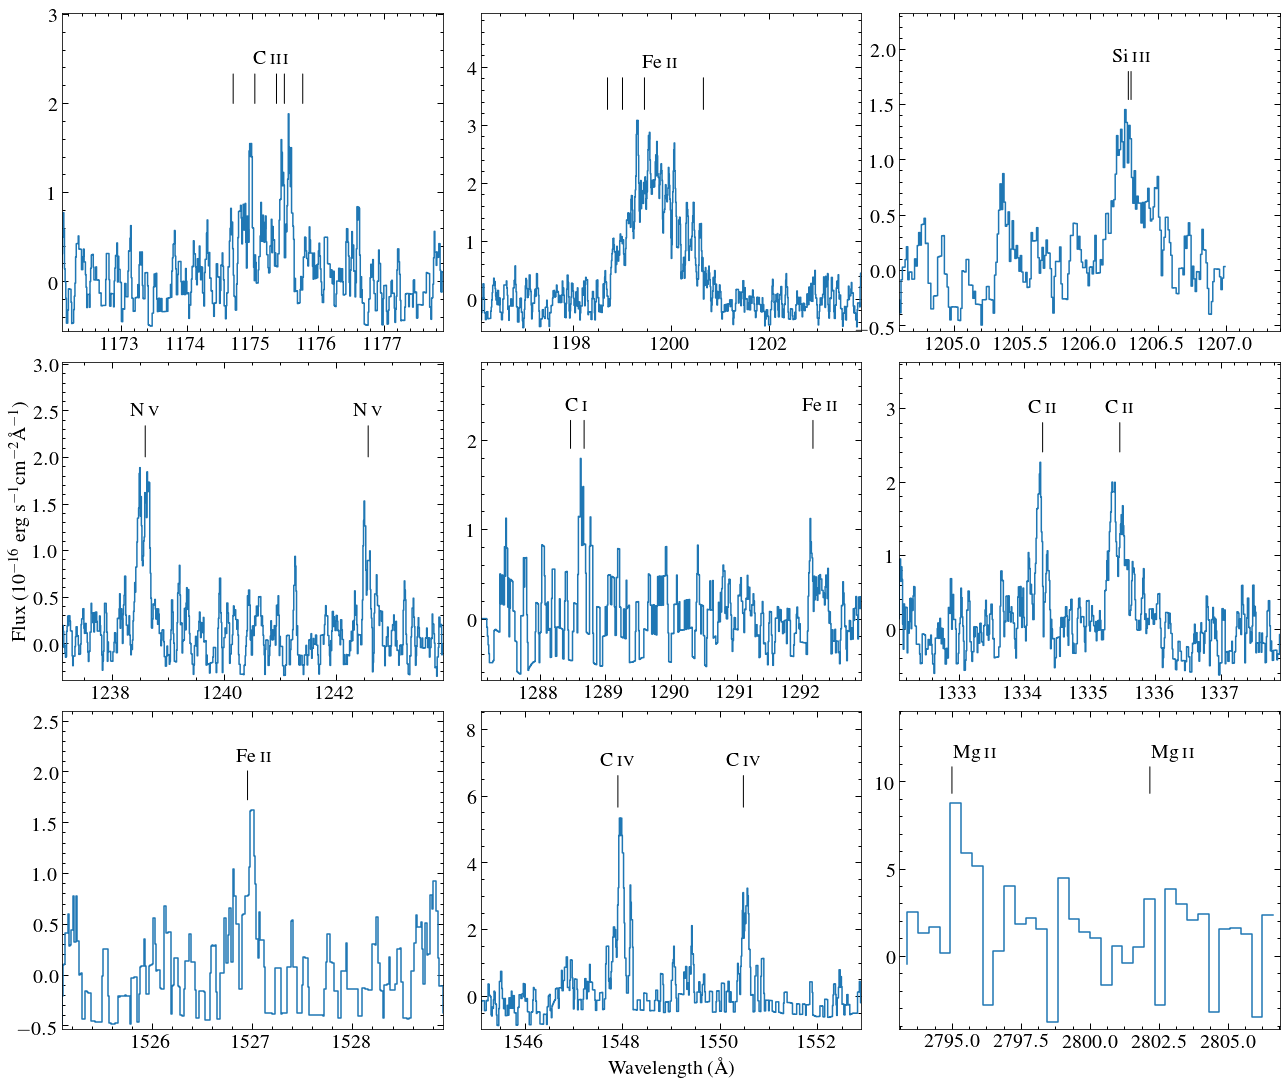

In [7]:
dv = -56300 #Bourrier+17a 
c = const.c.value
dshift = (1.0+(dv/c))
print(dshift)

plotlines = [1175, 1200, 1206.5, 1240, 1290, 1335, 1527, 1549, 2800]
plot_name = np.array(['C\,{\sc iii}', 'Fe\,{\sc ii}', 'Si\,{\sc iii}', 'N\,{\sc v}', 'N\,{\sc v}', 'C\,{\sc i}', 'Fe\,{\sc ii}', 'C\,{\sc ii}', 'C\,{\sc ii}', 'Fe\,{\sc ii}',
                      'C\,{\sc iv}', 'C\,{\sc iv}', 'Mg\,{\sc ii}', 'Mg\,{\sc ii}'])  
xlims = [[2.9,2.9], [3.9,3.9],[1.9,0.9],[2.9,3.9],[2.9,2.9],[2.9,2.9],[1.9,1.9],[3.9,3.9],[6.9,6.9]]
#C\,{\sc iv}
plt.figure(figsize=(18,15))
plt.subplots_adjust(hspace=0.1, wspace=0.1,top=0.99, right=0.99, left = 0.05, bottom =0.05)
for i in range(len(plotlines)):
    pl = plotlines[i]
    mask = (w > pl-7) & (w < pl+7)
    w1, f1 = w[mask], f[mask]
    plt.subplot(3,3,i+1)
    if i < 8:
        f1 = convolve(f1,Box1DKernel(5))
    f1 *= 1e16
    plt.step(w1, f1)
    mask2 = (w1 > pl-xlims[i][0]) & (w1 < pl+xlims[i][1])
    top = max(f1[mask2])
    bottom = min(f1[mask2])
    nmask = (lines > pl-5) & (lines < pl+5)
    #[plt.annotate(name,(line, top*1.05), xytext=(line, top*1.3),arrowprops=dict(arrowstyle='-'), horizontalalignment='center') for name, line in zip(plot_name[nmask], lines[nmask])]
    #[plt.annotate(name+'\n$|$', (line, top*1.1), horizontalalignment='center') for name, line in zip(plot_name[nmask], lines[nmask])]
    plt.ylim(bottom*1.1, top*1.6)
    plt.xlim(pl - xlims[i][0], pl + xlims[i][1])
    if i ==3:
        plt.ylabel('Flux ($10^{-16}$ erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)')
    if i == 7:
        plt.xlabel('Wavelength (\AA)')
    #if i == 6:
     #plt.annotate('C\,{\sc iv}', xy=(1550, top*1.1), xycoords='data', xytext=(-20, 15), textcoords='offset points', arrowprops=dict(arrowstyle="-[",connectionstyle="arc3"))
    
    [plt.annotate(name,(line*dshift, top*1.05), xytext=(line*dshift, top*1.3), horizontalalignment='center') for name, line in zip(plot_name[nmask], lines[nmask])]
    [plt.annotate('',(line*dshift, top*1.05), xytext=(line*dshift, top*1.25),arrowprops=dict(arrowstyle='-'), horizontalalignment='center') for line in all_lines[i]]

plt.savefig('t1_lines_grid_no_models.pdf', dpi=150)
        
        

What if each line was paired with it's semi-empirical model? Think I should treat the red mg line as an upper limit.

Siii flux

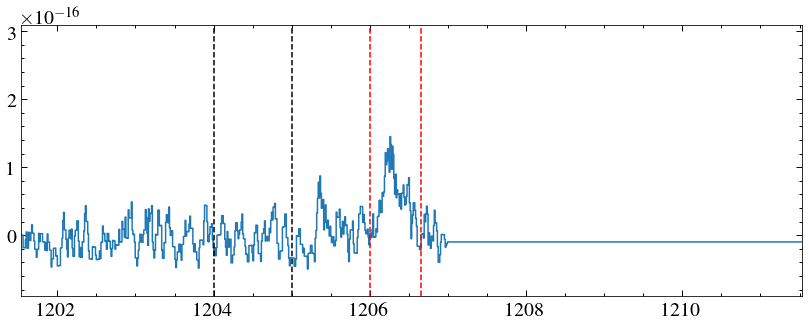

siii 1206.53 3.2992774766296944e-17 [2.90712475e-18]


In [14]:
lines = [1206.53]
line_names = ['siii']

line_edges = [[1206,1206.65]]
bgr = [[1204, 1205]]
line_width = np.diff(line_edges)
bgr_width = np.diff(bgr)
e_scale = line_width/bgr_width


fluxes = []
errors = []
for i in range(len(lines)):
    line = lines[i]
    f1 = convolve(f,Box1DKernel(5))
    plt.step(w, f1)
    plt.xlim(line-5, line+5)
    plt.ylim(-0.9e-16,3.1e-16)
    [plt.axvline(l, ls ='--', c='r') for l in line_edges[i]]
    [plt.axvline(l, ls ='--', c='k') for l in bgr[i]]
    plt.show()

for i in range(len(lines)):
    line_mask = (w > line_edges[i][0]) & (w < line_edges[i][1])
    int_flux = np.trapz(f[line_mask], w[line_mask])
    bg_mask = (w > bgr[i][0]) & (w < bgr[i][1])
    bg_flux = np.trapz(f[bg_mask], w[bg_mask])*e_scale[i]
    print(line_names[i], lines[i], int_flux, abs(bg_flux))
    fluxes.append(int_flux)
    errors.append(abs(bg_flux))

siii 1206.53 3.3 0.3

Let's (sigh) try some fitting.

In [9]:
fitter = fitting.SLSQPLSQFitter()


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 119.22581804407363
            Iterations: 30
            Function evaluations: 572
            Gradient evaluations: 30
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 121.22590560833234
            Iterations: 97
            Function evaluations: 1111
            Gradient evaluations: 97
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 336.4738809792997
            Iterations: 20
            Function evaluations: 186
            Gradient evaluations: 20
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 139.8006846048051
            Iterations: 21
            Function evaluations: 194
            Gradient evaluations: 21
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 88.6085259831744
            Iterations: 10
            Functi

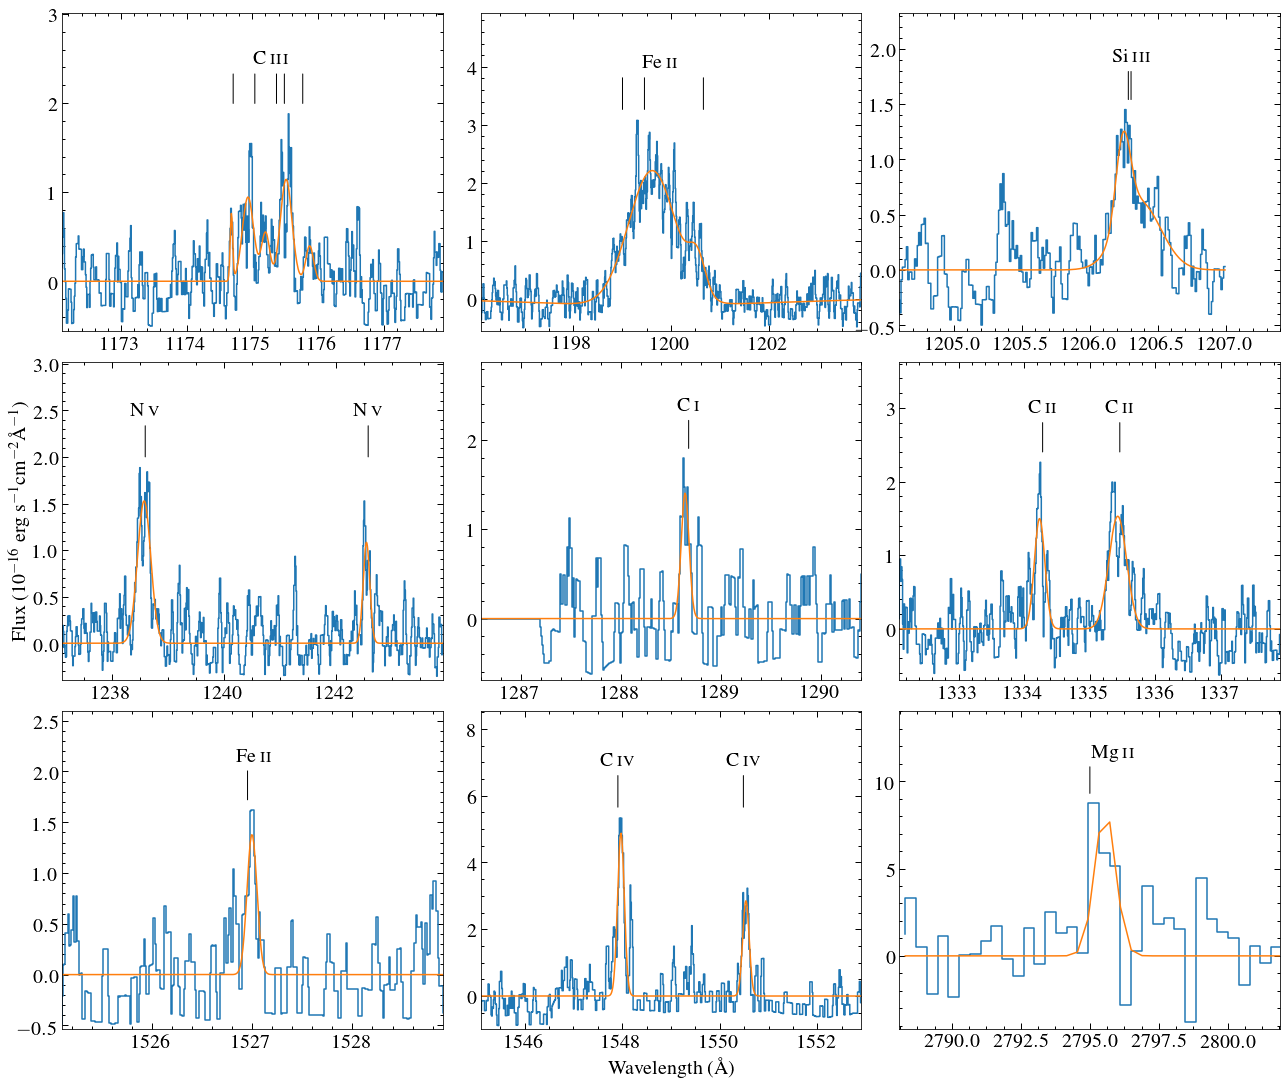

In [22]:
#note these ones are tweaked for the fit

plot_name = np.array(['C\,{\sc iii}', 'Fe\,{\sc ii}', 'Si\,{\sc iii}', 'N\,{\sc v}', 'N\,{\sc v}', 'C\,{\sc i}',  'C\,{\sc ii}', 'C\,{\sc ii}', 'Fe\,{\sc ii}',
                      'C\,{\sc iv}', 'C\,{\sc iv}', 'Mg\,{\sc ii}', 'Mg\,{\sc ii}'])  
lines = np.array([1175.5, 1200, 1206.53,1238.821, 1242.804,1288.918, 1334.532, 1335.708 ,1527.3 ,1548.202,1550.774 ,2796.35 ,2803.53])

plotlines = [1175, 1200, 1206.5, 1240, 1288.5, 1335, 1527, 1549, 2795]

xlims = [[2.9,2.9], [3.9,3.9],[1.9,0.9],[2.9,3.9],[1.9,1.9],[2.9,2.9],[1.9,1.9],[3.9,3.9],[6.9,6.9]]

ciii_1175 = [1174.93,1175.26,1175.59,1175.71,1175.99]
feii_1200 =[1199.231,1199.681,1200.889]
siiii_1206 = [1206.51, 1206.53]
nv_1240 = [1238.821, 1242.804]
ci_1288 = [1288.918]
feii_1292 = [1292.405]
cii_1335 = [1334.532, 1335.708]
feii_1527 = [1527.2397] 
civ_1550 = [1548.202,1550.774]
mgii_2800 = [2795.528]


all_lines = [ciii_1175, feii_1200, siiii_1206, nv_1240, ci_1288, cii_1335, feii_1527, civ_1550, mgii_2800]


all_lines[4] = ci_1288
#all_lines[-1] =[2795.528]
gauss_int  = []
plt.figure(figsize=(18,15))
plt.subplots_adjust(hspace=0.1, wspace=0.1,top=0.99, right=0.99, left = 0.05, bottom =0.05)
for i in range(len(plotlines)):
    pl = plotlines[i]
    mask = (w > pl-7) & (w < pl+7)
    w1, f1, e1  = w[mask], f[mask], e[mask]
    plt.subplot(3,3,i+1)
    if i < 8:
        f1 = convolve(f1,Box1DKernel(5))
        e1 = convolve(e1,Box1DKernel(5))
    f1 *= 1e16
    e1 *= 1e16
    plt.step(w1, f1)
    mask2 = (w1 > pl-xlims[i][0]) & (w1 < pl+xlims[i][1])
    top = max(f1[mask2])
    bottom = min(f1[mask2])
    nmask = (lines > pl-5) & (lines < pl+5)
    plt.ylim(bottom*1.1, top*1.6)
    plt.xlim(pl - xlims[i][0], pl + xlims[i][1])
    if i ==3:
        plt.ylabel('Flux ($10^{-16}$ erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)')
    if i == 7:
        plt.xlabel('Wavelength (\AA)')
    [plt.annotate(name,(line*dshift, top*1.05), xytext=(line*dshift, top*1.3), horizontalalignment='center') for name, line in zip(plot_name[nmask], lines[nmask])]
    [plt.annotate('',(line*dshift, top*1.05), xytext=(line*dshift, top*1.25),arrowprops=dict(arrowstyle='-'), horizontalalignment='center') for line in all_lines[i]]
    
    guess_sigma = 0.05
    if i == 8:
        guess_sigma = 0.1
    gg_init = models.Gaussian1D(1.0, all_lines[i][0]*dshift, guess_sigma)
    for line in all_lines[i][1:]:
        gg_init = gg_init + models.Gaussian1D(1.0, line*dshift, guess_sigma)
    gg_fit = fitter(gg_init, w1, f1)
    plt.plot(w1, gg_fit(w1))
    gauss_int.append(np.trapz(gg_fit(w1), w1))
    if i == 0:
        lines_model = gg_fit
    else:
        lines_model = lines_model + gg_fit

plt.savefig('t1_lines_grid_fit.pdf', dpi=150)
     
        

In [60]:
print(np.array(gauss_int)*1e-16)

[6.40553559e-17 2.59093521e-16 3.46795014e-17 6.16234332e-17
 1.08561540e-17 8.23798289e-17 1.71816678e-17 1.32794576e-16
 1.83874819e-15]


name line(A) flux(e-17 erg s-1 cm-2) error (e-17 erg s-1 cm-2) gauss (e-17 erg s-1 cm-2)  
ciii 1175 6.0 0.2 6.4  
feii 1200 27.7 1.1 26  
siiii 1206.53 3.3 0.3 3.5   
nv 1238.821 4.35 0.7    
nv 1242.804 2.31 0.88 = 6.66, g=6.2  
ci 1288 1.3 0.1 1.1  
feii 1292 <1  
cii 1334.532 3.20 0.51   
cii 1335.708 5.37 0.80 =8.57, g=8.2  
feii 1527 2.2 0.3 1.7   
civ 1548.202 10.8 0.90  
civ 1550.774 4.39 0.67 =15.19, g=13.3  
mgii 2796.35 71.0 6.5  
mgii 2803.53 33 6.0 = 104, g==183  

Tweak, then make one combined spectrum?

In [73]:
lines_model

<CompoundModel581(amplitude_0=1., mean_0=1174.70935216, stddev_0=0.05, amplitude_1=1., mean_1=1175.03929018, stddev_1=0.05, amplitude_2=1., mean_2=1175.36922821, stddev_2=0.05, amplitude_3=1., mean_3=1175.48920568, stddev_3=0.05, amplitude_4=1., mean_4=1175.76915309, stddev_4=0.05, amplitude_5=1., mean_5=1199.00578851, stddev_5=0.05, amplitude_6=1., mean_6=1199.455704, stddev_6=0.05, amplitude_7=1., mean_7=1200.66347715, stddev_7=0.05, amplitude_8=1., mean_8=1206.28342154, stddev_8=0.05, amplitude_9=1., mean_9=1206.30341779, stddev_9=0.05, amplitude_10=1., mean_10=1238.58835365, stddev_10=0.05, amplitude_11=1., mean_11=1242.57060565, stddev_11=0.05, amplitude_12=1.40590456, mean_12=1288.64065327, stddev_12=0.03926656, amplitude_13=1., mean_13=1334.28137945, stddev_13=0.05, amplitude_14=1., mean_14=1335.4571586, stddev_14=0.05, amplitude_15=1.38447046, mean_15=1526.99747551, stddev_15=0.04950986, amplitude_16=1., mean_16=1547.91125295, stddev_16=0.05, amplitude_17=1., mean_17=1550.48276

Ok, what does that look like when added to the phoenix spectrum?

In [74]:
sph = Table.read('../optical/scaled_02560-5.00-0.0_phoenix_trappist-1.ecsv')

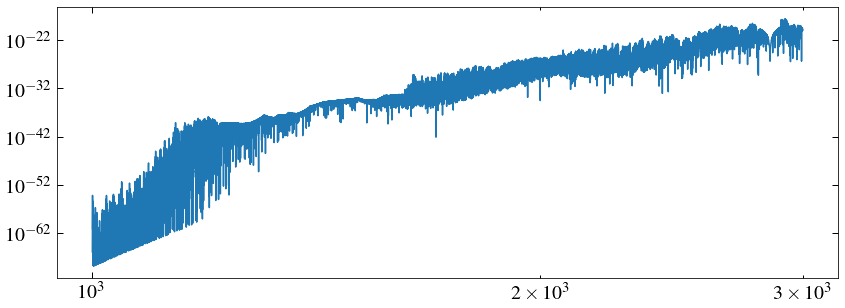

In [83]:
mw, mf = sph['WAVELENGTH'], sph['FLUX']
uv_mask = (mw > 1000) & (mw < 3000)
mw, mf = mw[uv_mask], mf[uv_mask]
plt.plot(mw, mf)
plt.xscale('log')
plt.yscale('log')

(1100, 1800)

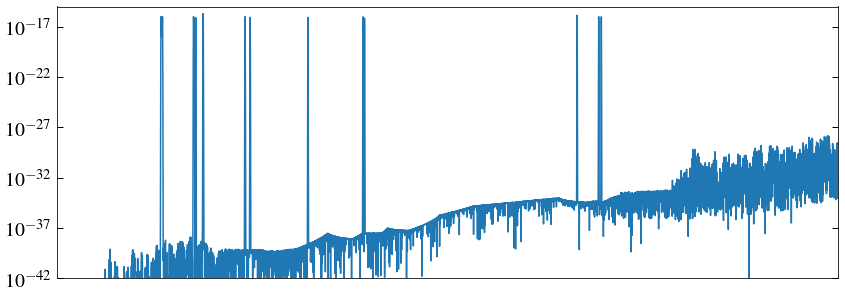

In [89]:
smf = mf + lines_model(mw)*1e-16
plt.plot(mw, smf)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-42,1e-15 )
plt.xlim(1100, 1800)

How does this compare to the ray data?

In [90]:
#fdt = Table.read('../combined/trappist-1_sed_var_res_blya.ecsv')

In [91]:
w, f = fdt['WAVELENGTH'], fdt['FLUX']


Text(0.5, 0, 'Wavelength (\\AA)')

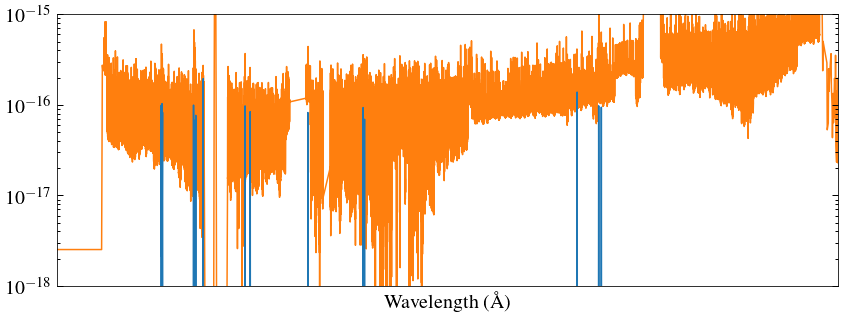

In [99]:
plt.plot(mw, smf)
plt.plot(w[f>0],f[f>0], zorder=-1)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-18,1e-15 )
plt.xlim(1100, 1800)
plt.xlabel('Wavelength (\AA)')

Lines not poking up high enough? Or just not above the noise?

20190517 measuring the lines in a consistant way, as well as comparing to P+ models

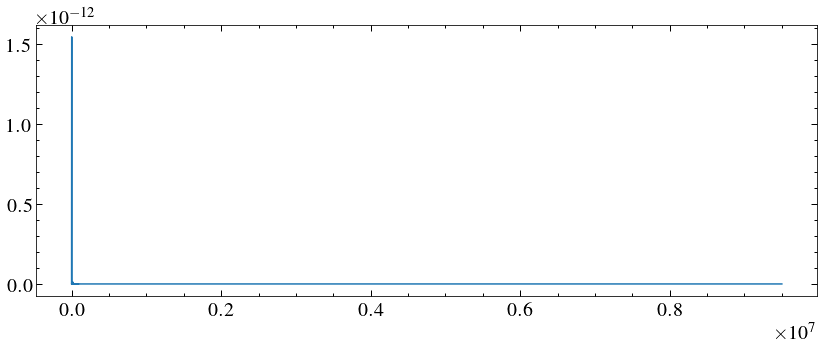

Switching to a script line_flux.py, will make zooming easier

In [120]:
#results from line_flux/py
#C\,{\sc iii} 1175.5 0.6405350225540571 [0.07844177]
#Fe\,{\sc ii} 1200.0 2.7894047778525395 [0.23985992]
#Si\,{\sc iii} 1206.53 0.3456705565752145 [0.10187653]
#N\,{\sc v} 1238.821 0.4538070444455654 [0.09874083]
#N\,{\sc v} 1242.804 0.16194009846461357 [0.02817738]
#C\,{\sc i} 1288.8 0.13831405722821305 [0.0280558]
#C\,{\sc ii} 1334.532 0.30040669376985896 [0.00823153]
#C\,{\sc ii} 1335.708 0.5231827253207872 [0.60975433]
#Fe\,{\sc ii} 1527.3 0.1718001417567793 [0.039704]
#C\,{\sc iv} 1548.202 0.8493098440285094 [0.05039343]
#C\,{\sc iv} 1550.774 0.47813836840486157 [0.12910409]
#Mg\,{\sc ii} 2796.35 7.8822372470082955 [0.8100198]




#name line(A) flux(e-17 erg s-1 cm-2) error (e-17 erg s-1 cm-2) gauss (e-17 erg s-1 cm-2)  


name line(A) flux(e-17 erg s-1 cm-2) error (e-17 erg s-1 cm-2)   
C\,{\sc iii} 1175.5 6.4 0.8  
Fe\,{\sc ii} 1200.0 27.9 2.4  
Si\,{\sc iii} 1206.53 3.5 0.1  
N\,{\sc v} 1238.821 4.5 1.0  
N\,{\sc v} 1242.804 1.6 0.3  
C\,{\sc i} 1288.8 1.4 0.3  
C\,{\sc ii} 1334.532 3.0 0.1  
C\,{\sc ii} 1335.708 5.2 0.1 ?  
Fe\,{\sc ii} 1527.3 1.7 0.4  
C\,{\sc iv} 1548.202 8.5 0.5  
C\,{\sc iv} 1550.774 4.8 1.3?  
Mg\,{\sc ii} 2796.35 79 8  